# AHCCD (Adjusted and Homogenized Canadian Climate Data)

### The following is an exercise in formating, combining, plotting and interpolating the adjusted and homogenized canadian climate data for multiple climate variable measurements taken at stations across Canada since, in some cases, as early as 1840.

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import PolynomialFeatures


### Processing AHCCD sttation data and combining into a single csv file:

In [ ]:
import pandas as pd
import os
import re

def remove_whitespace_before_year(file_path):#removing whitespace before the word 'year' in the txt file
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        lines = file.readlines()
        
        if lines[2].lstrip().startswith('Year'):#check if whitespace before year
        lines[2] = lines[2].lstrip()  #remove tthe whitespace
    
    with open(file_path, 'w', encoding='ISO-8859-1') as file:#rewrite the file
        file.writelines(lines)

for folder_path in input_folders:#removing whitespace across files
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            remove_whitespace_before_year(file_path)

def read_station_metadata(metadata_file):#loading the sations metadata to pull coordiinate values and names etc...
    metadata = pd.read_csv(metadata_file, dtype={'StnId': str})#clarifying the station name is a string
    return metadata[['StnId', 'Station name', 'Lat(deg)', 'Long(deg)', 'Elev(m)']]

def process_file(file_path, var_name, metadata):
    with open(file_path, 'r', encoding='ISO-8859-1') as f:#open given file and read lines
        lines = f.readlines()

    station_id = lines[0].split(',')[0].strip()#take station ID from firs cell in csv and make it a string to match with metadata
    station_id = str(station_id)
    
    data = pd.read_csv(#reading data with removed headers
        file_path,
        skiprows=[0, 1, 2, 3],
        header=None,
        encoding='ISO-8859-1',
        on_bad_lines='skip'
    )
    
    selected_columns = [0] + list(range(1, 34, 2))#selecting columns to extract data from
    data = data.iloc[:, selected_columns]
    print(data)#checking dataframe makes sense
    
    month_columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual', 'Winter', 'Spring', 'Summer', 'Autumn']
    data.columns = month_columns#rename columns according to months etc
    
    data.replace(-9999.9, pd.NA, inplace=True)#replace 9999.9 with NaN
    
    data['Station ID'] = station_id #adding columns
    data['Value Type'] = var_name
    
    # Lookup station information from metadata
    station_info = metadata[metadata['StnId'] == station_id]#finding station metadata by station ID
    if station_info.empty:
        print(f"No metadata found for station ID {station_id}")
        return pd.DataFrame()
    
    station_info = station_info.iloc[0]#adding columns from metadata
    data['Station'] = station_info['Station name']
    data['Latitude'] = station_info['Lat(deg)']
    data['Longitude'] = station_info['Long(deg)']
    data['Elevation'] = station_info['Elev(m)']

    return data

def collect_data(folder_path, var_name, metadata): #performs all previous functions and collects data from separate files
    all_data = pd.DataFrame()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            print(f"Processing file: {file_path}")
            station_data = process_file(file_path, var_name, metadata)
            all_data = pd.concat([all_data, station_data], ignore_index=True)
    
    return all_data

def save_to_csv(output_path, folder_paths, folder_names, metadata): #saving data to csv file
    all_data = pd.DataFrame()
    
    for folder_path, folder_name in zip(folder_paths, folder_names):
        folder_data = collect_data(folder_path, folder_name, metadata)
        all_data = pd.concat([all_data, folder_data], ignore_index=True)
    
    final_columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', #setting columns to appear in final csv file (filters through collected data)
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual', 'Winter', 
                     'Spring', 'Summer', 'Autumn', 'Station', 'Latitude', 
                     'Longitude', 'Elevation', 'Value Type']
    all_data = all_data[final_columns]
    
    all_data.to_csv(output_path, index=False)
    print(f"Data saved to {output_path}")

metadata_file = '/Users/maxMax/Desktop/Datasets/AHCCD_STATIONS.csv'
input_folders = [
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_min_temp_Gen3', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_max_temp_Gen3', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Adj_monthly_snow', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Adj_monthly_rain',
    '/Users/maxMax/Desktop/Datasets/AHCCD/Adj_monthly_total_prec', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_sea_level_pressure',
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_station_pressure', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_wind_speed', 
    '/Users/maxMax/Desktop/Datasets/AHCCD/Homog_monthly_mean_temp_Gen3'
]
folder_names = [
    'Min Temperature', 'Max Temperature', 'Snow', 'Rain',
    'Total Precipitation', 'Sea Level Pressure', 'Station Pressure', 'Mean Wind Speed', 'Mean Temperature'
]
output_csv = 'AHCCD.csv'

station_metadata = read_station_metadata(metadata_file)
save_to_csv(output_csv, input_folders, folder_names, station_metadata)


### Now need to confine the data to the select region in Eastern Canada we want to look at:

In [ ]:
import pandas as pd

data = pd.read_csv('AHCCD.csv')

lat_min, lat_max = 40, 63
lon_min, lon_max = -81, -50

confined_data = data[(data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) &
                     (data['Longitude'] >= lon_min) & (data['Longitude'] <= lon_max)]

confined_data.to_csv('AHCCD_CONFINED.csv', index=False)

print("Filtered data saved to 'AHCCD_CONFINED.csv'")


### Plotting all stations on map:

/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44193/319809402.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


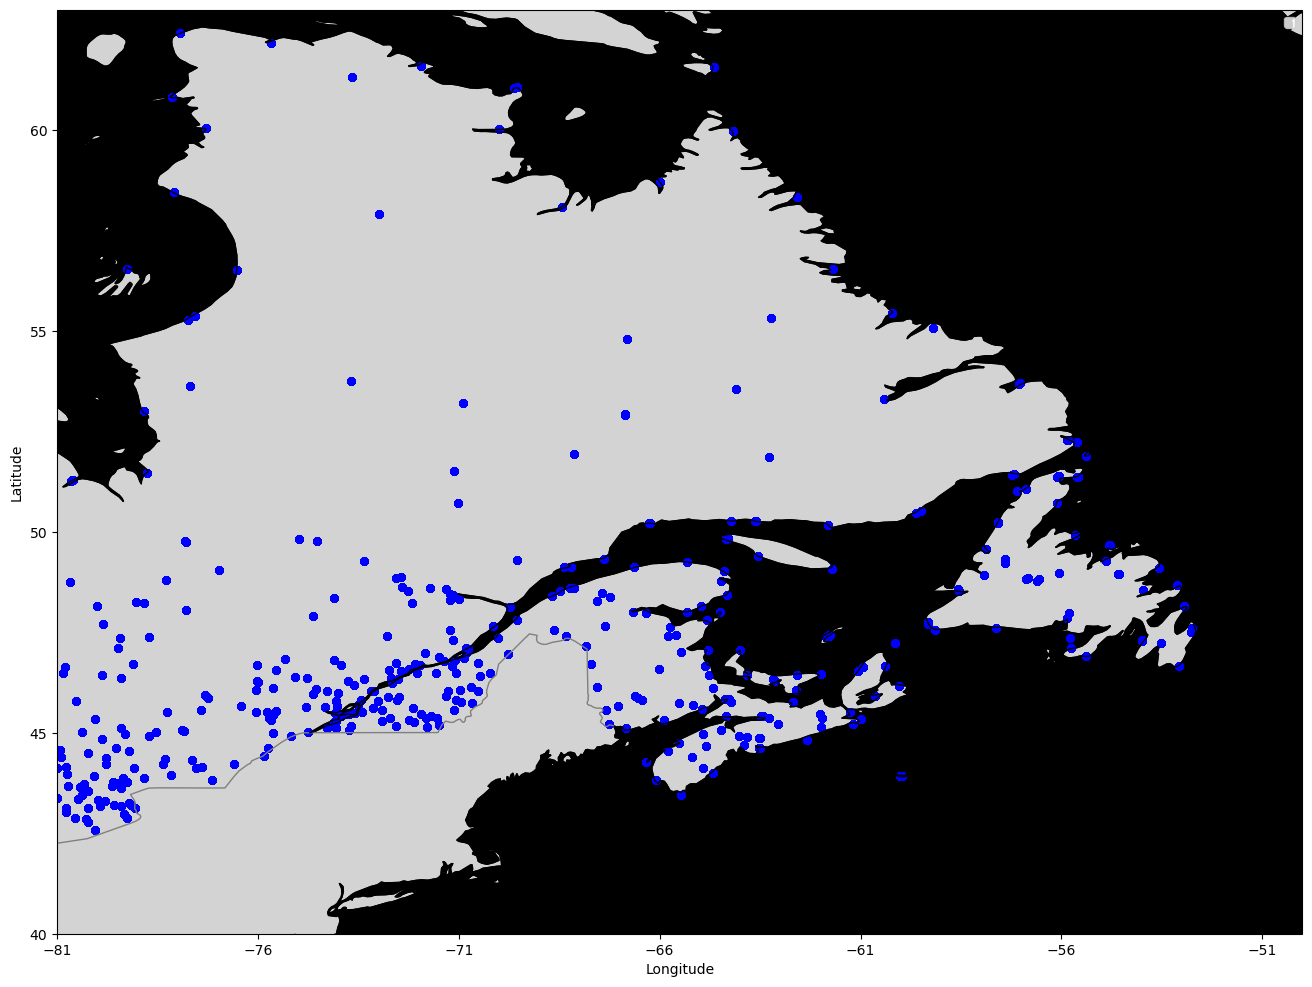

In [126]:
ecws_data_test = pd.read_csv('AHCCD_CONFINED.csv')

ecws_lon46 = ecws_data_test['Longitude']
ecws_lat46 = ecws_data_test['Latitude']

lat_min, lat_max = 40, 63
lon_min, lon_max = -81, -50

fig, ax = plt.subplots(figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='black')
ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())

plt.scatter(ecws_lon46, ecws_lat46, color='blue', s=25, marker='o', transform=ccrs.PlateCarree())

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.show()


### Plotting stations with data available for individual vaariables:

['Min Temperature' 'Max Temperature' 'Snow' 'Rain' 'Total Precipitation'
 'Sea Level Pressure' 'Station Pressure' 'Mean Wind Speed'
 'Mean Temperature']


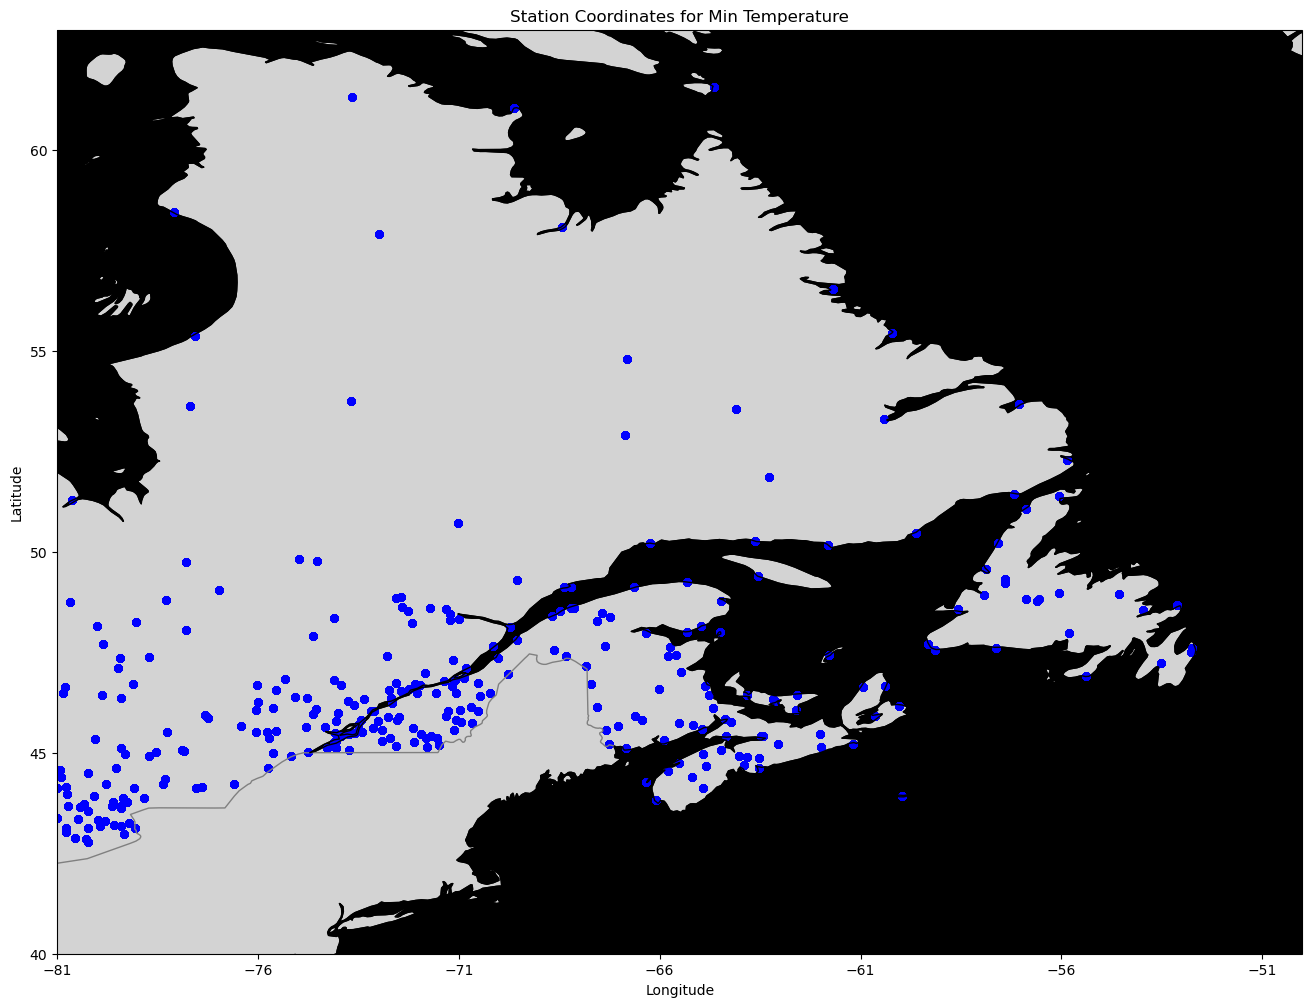

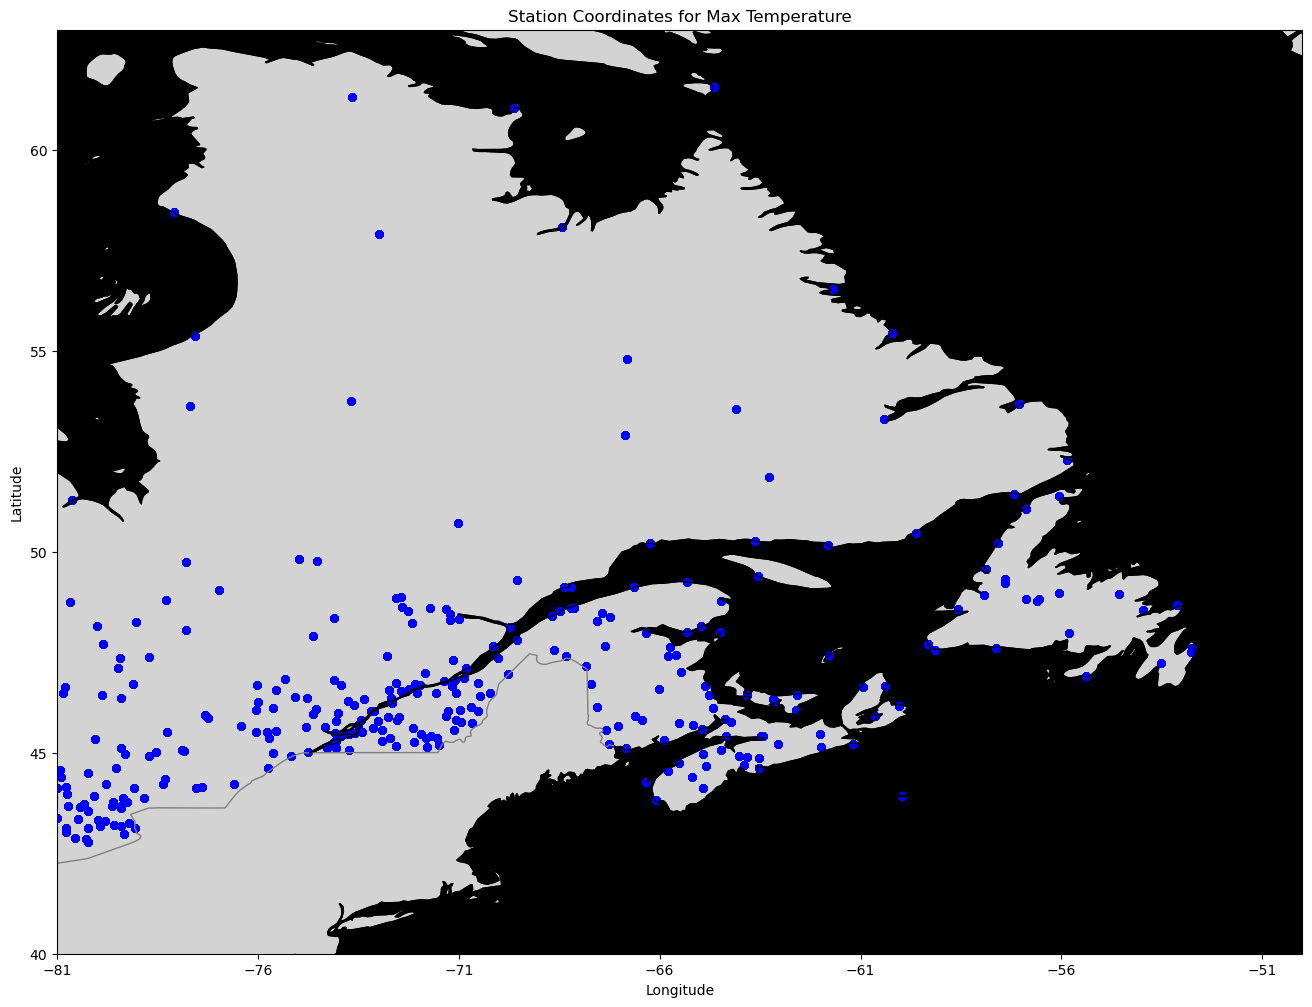

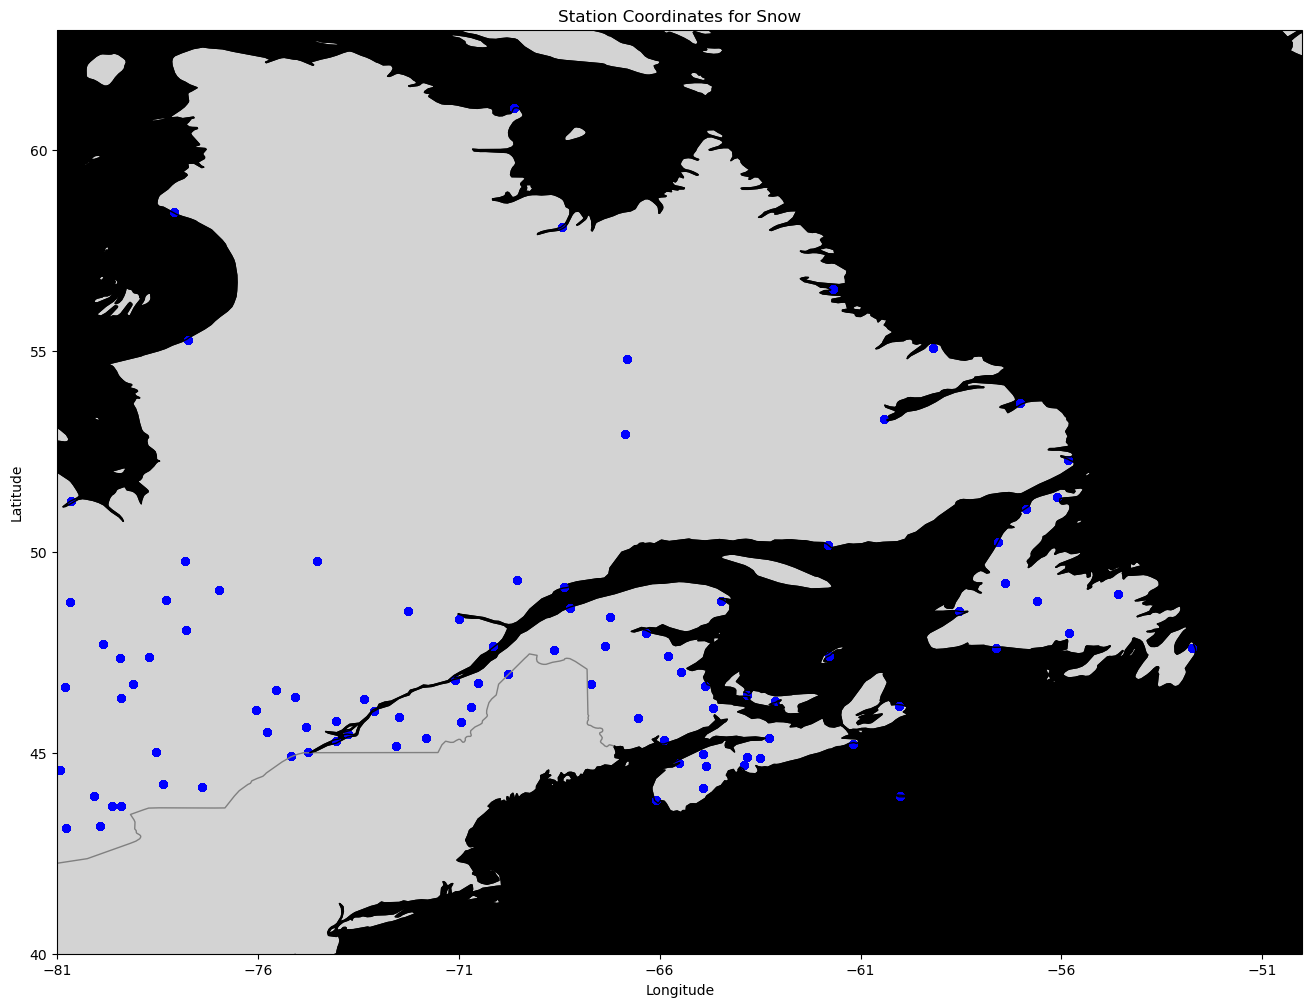

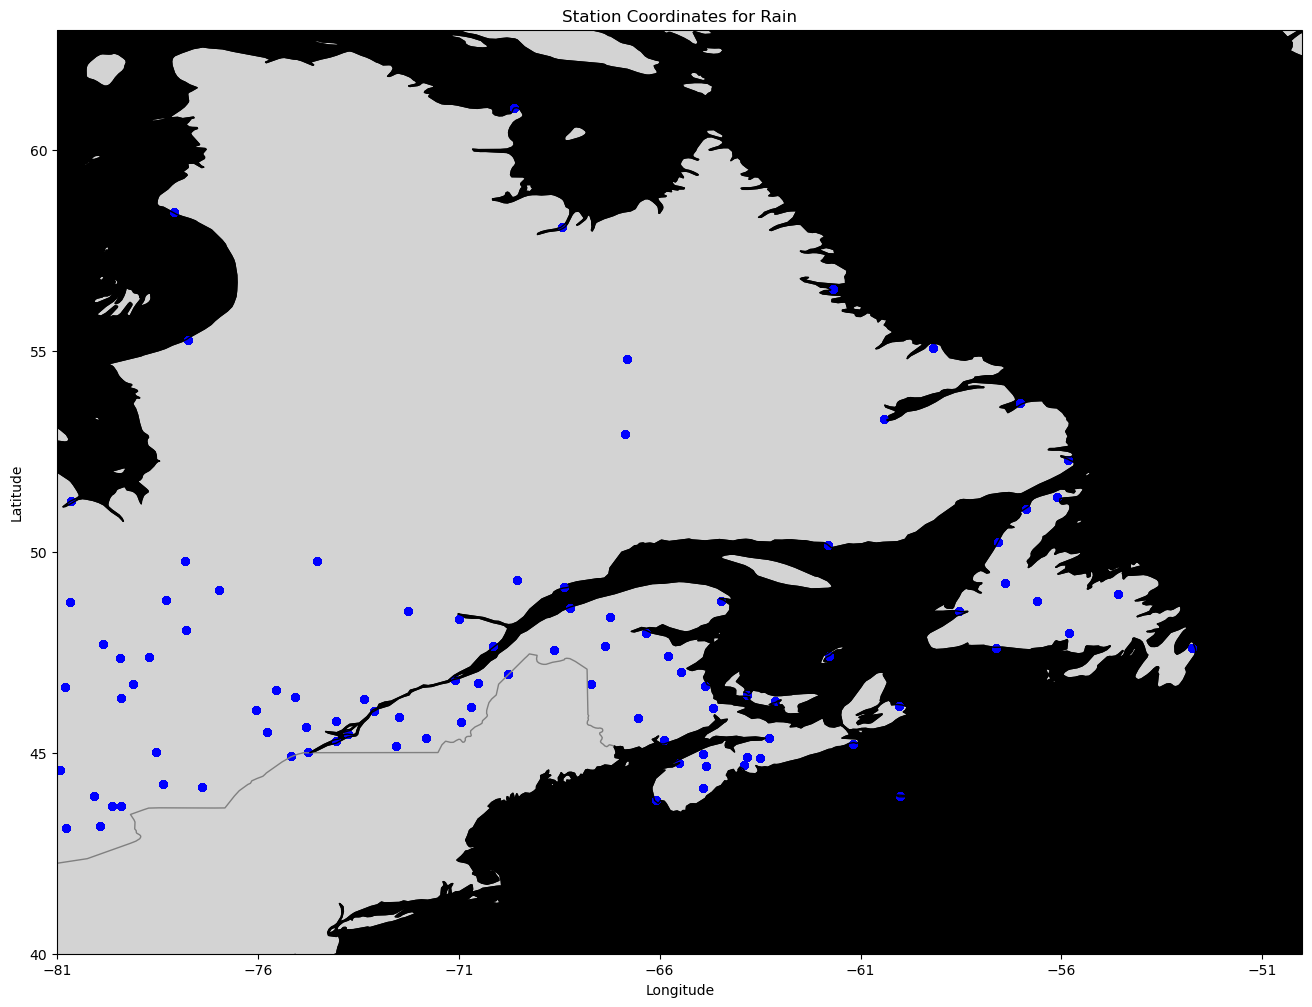

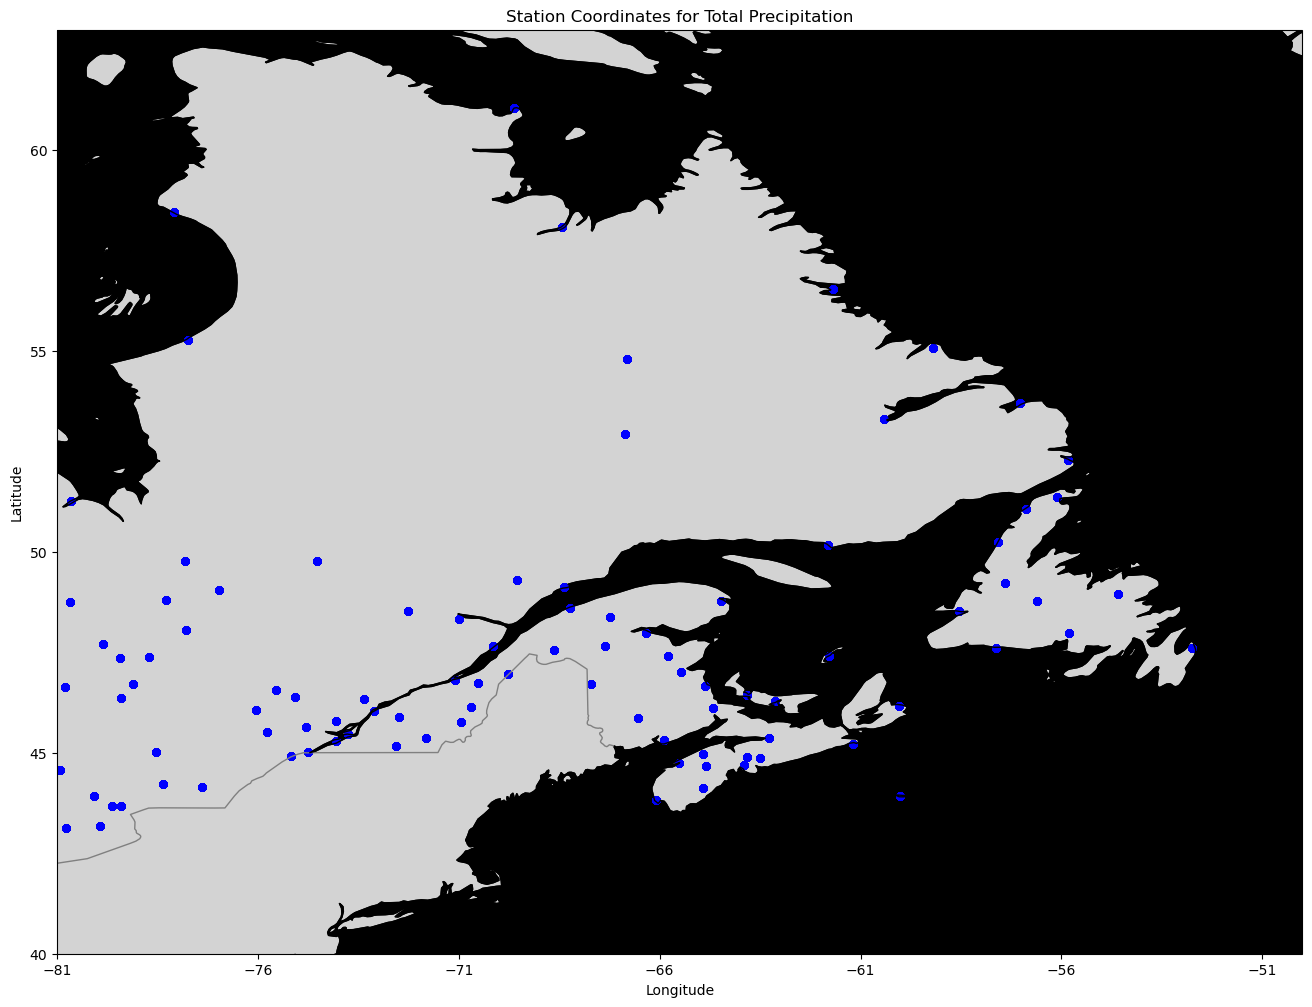

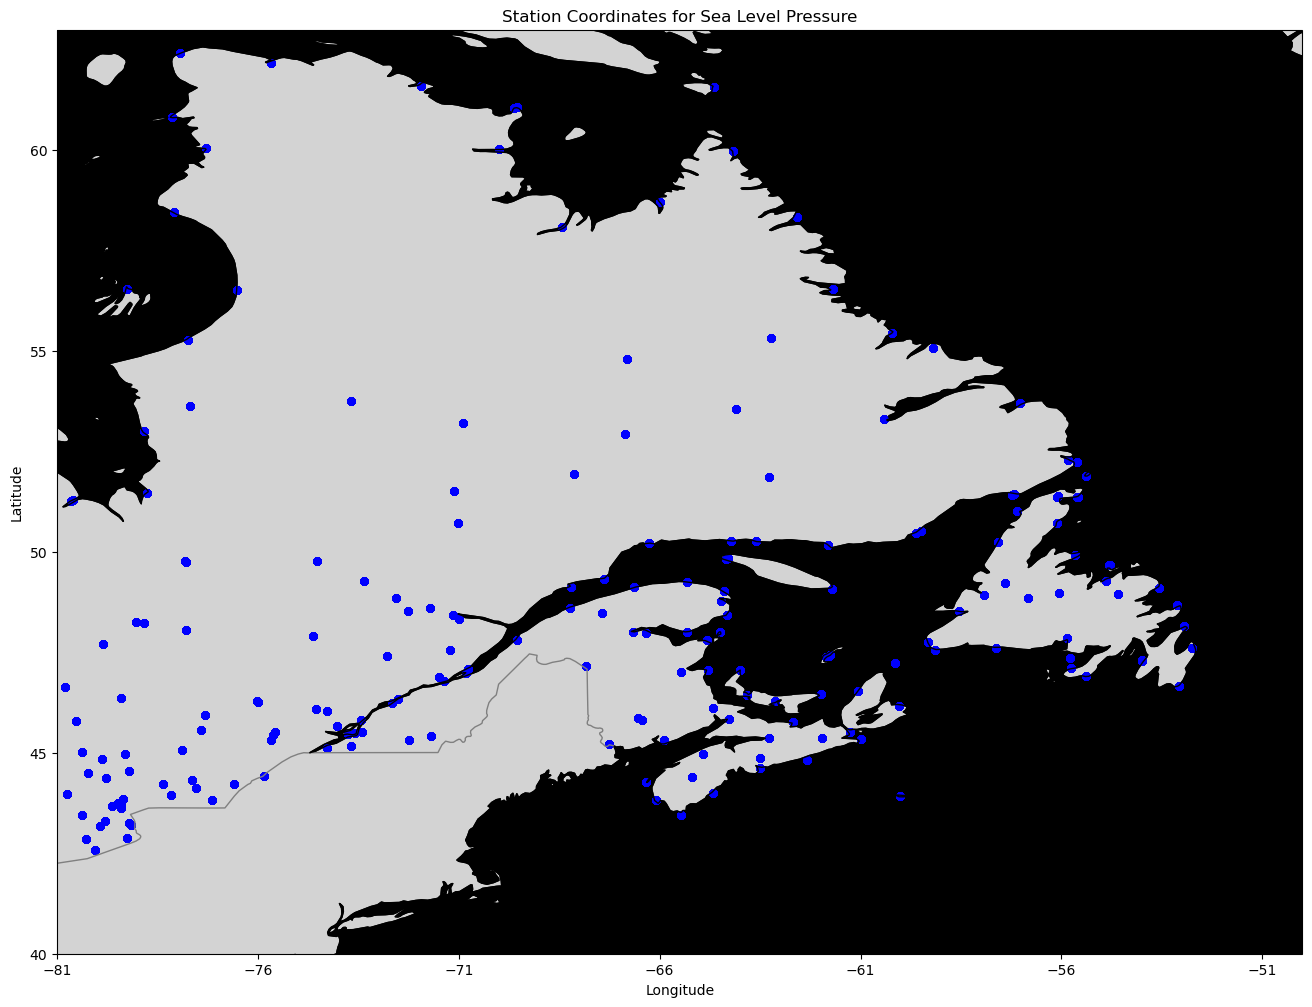

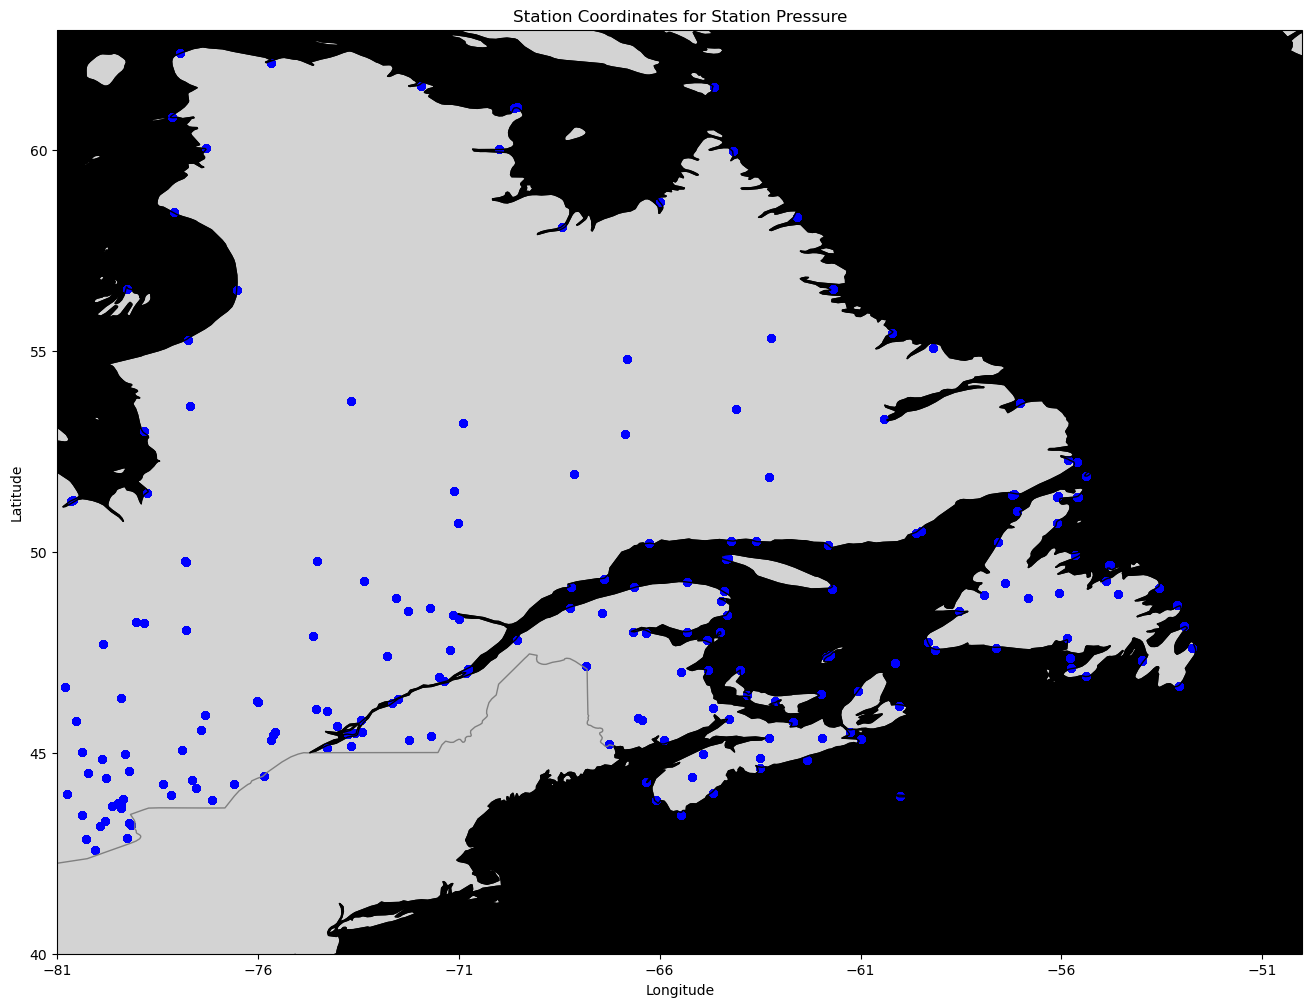

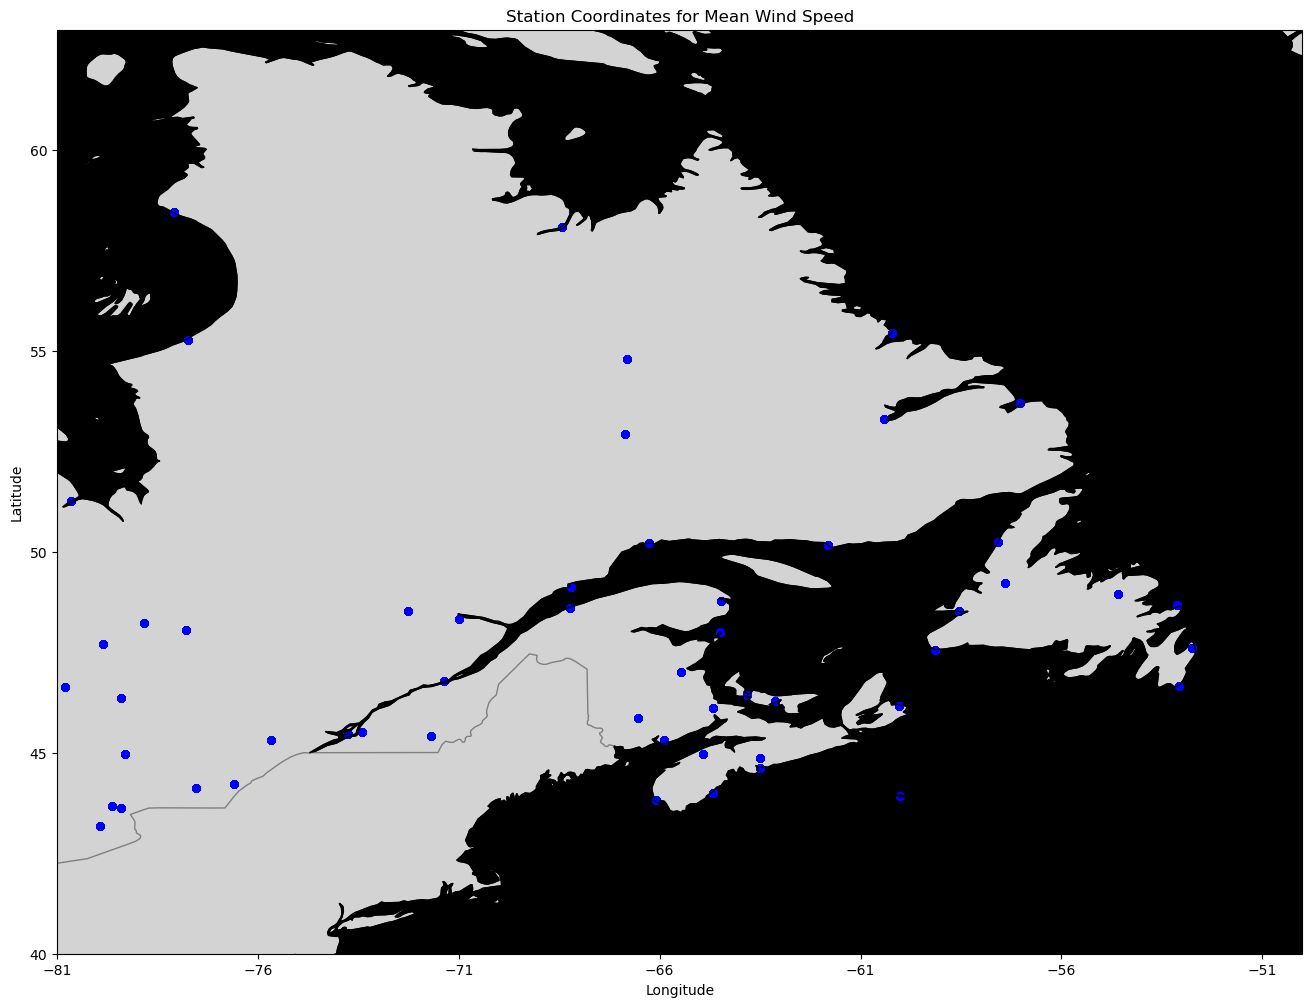

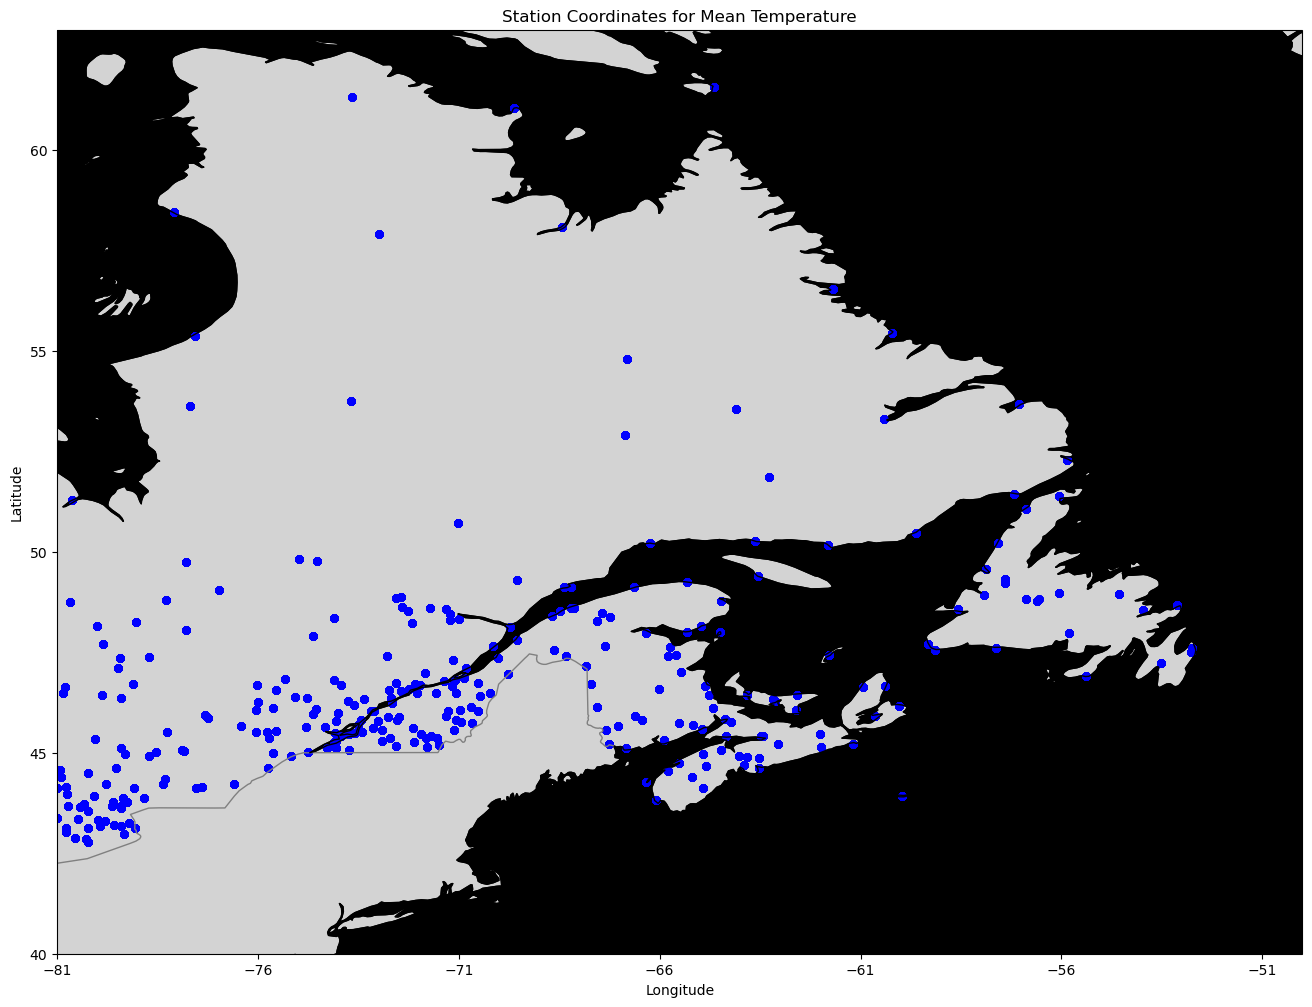

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

ecws_data_test = pd.read_csv('AHCCD_CONFINED.csv')

lat_min, lat_max = 40, 63
lon_min, lon_max = -81, -50

variable_types = ecws_data_test['Value Type'].unique()#get unique variable types
print(variable_types)
for var_type in variable_types: #loop through each variable type and plot
    data_subset = ecws_data_test[ecws_data_test['Value Type'] == var_type] #filter data for specified variable type
    ecws_lon = data_subset['Longitude']
    ecws_lat = data_subset['Latitude']
    
    fig, ax = plt.subplots(figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})#map
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='black')
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    
    plt.scatter(ecws_lon, ecws_lat, color='blue', s=25, marker='o', transform=ccrs.PlateCarree(), label=var_type)#scatter plot stattions
    
    plt.title(f'Station Coordinates for {var_type}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

### Ploting variable data with regression:

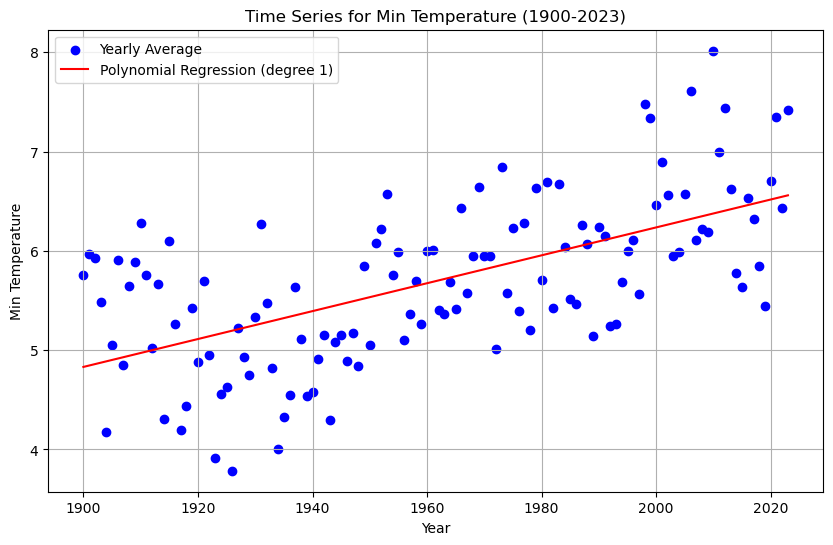

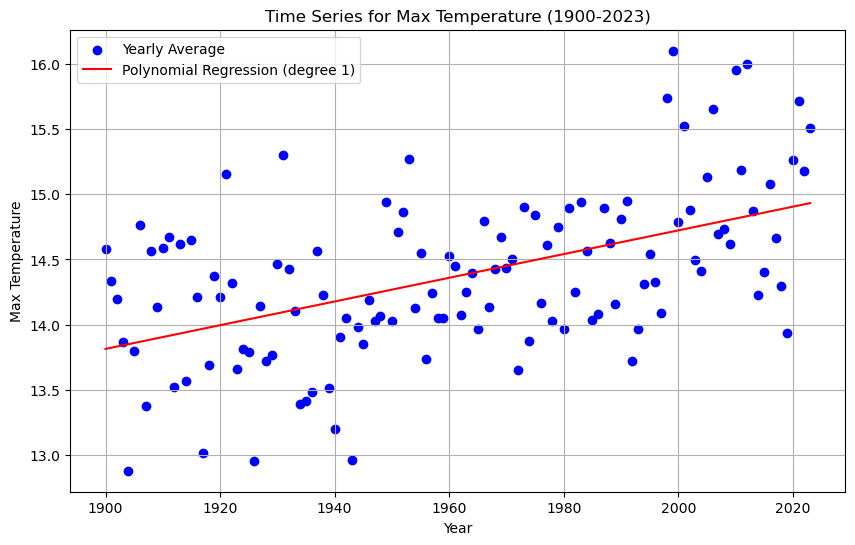

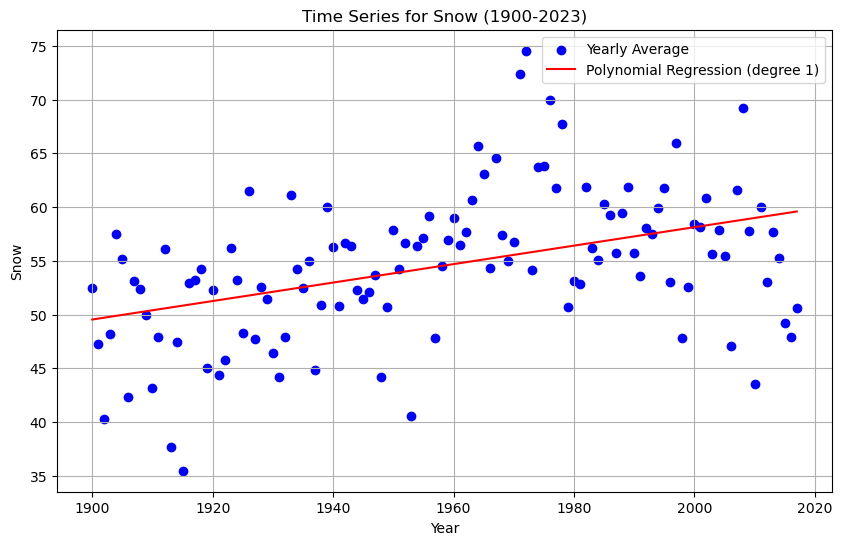

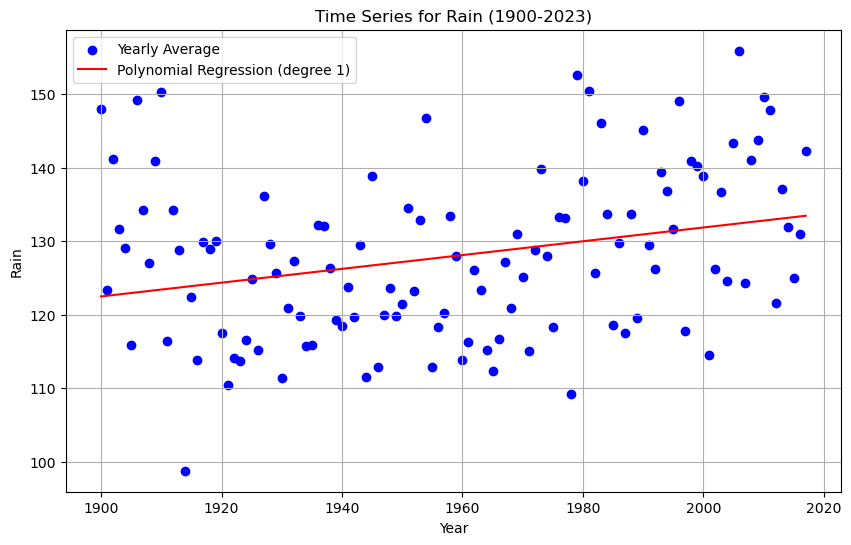

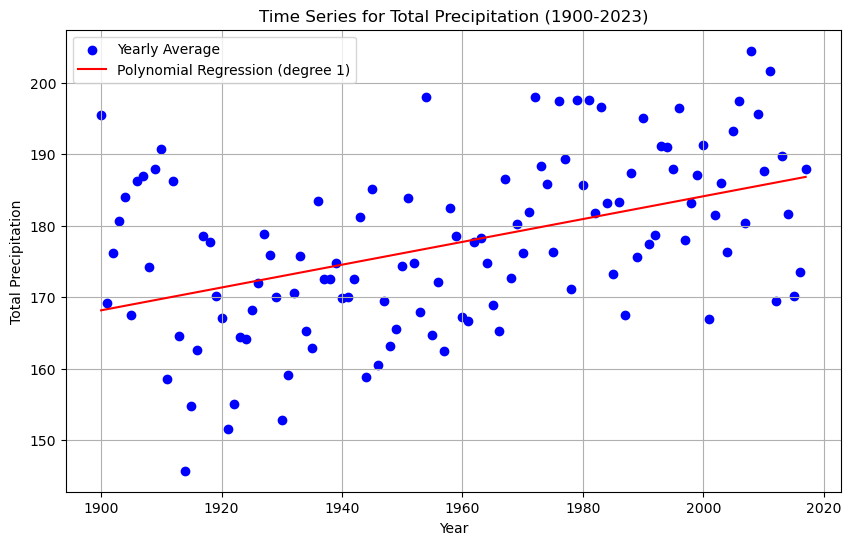

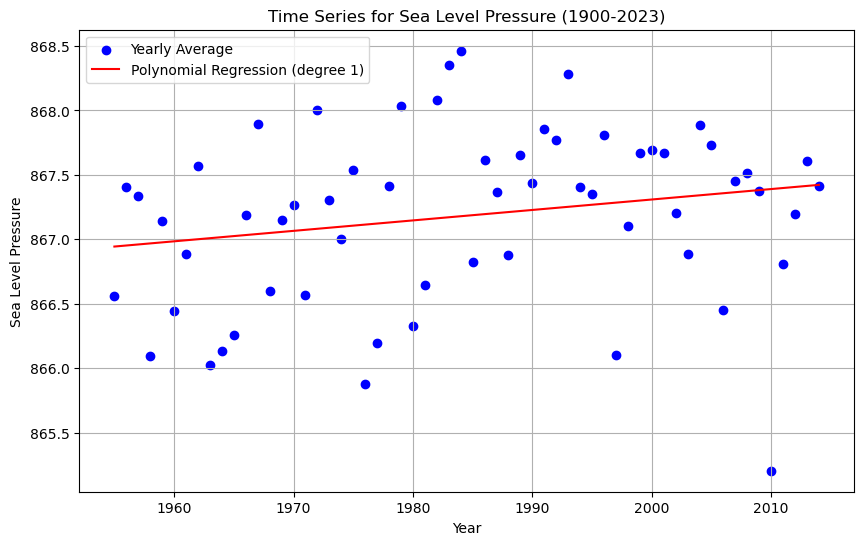

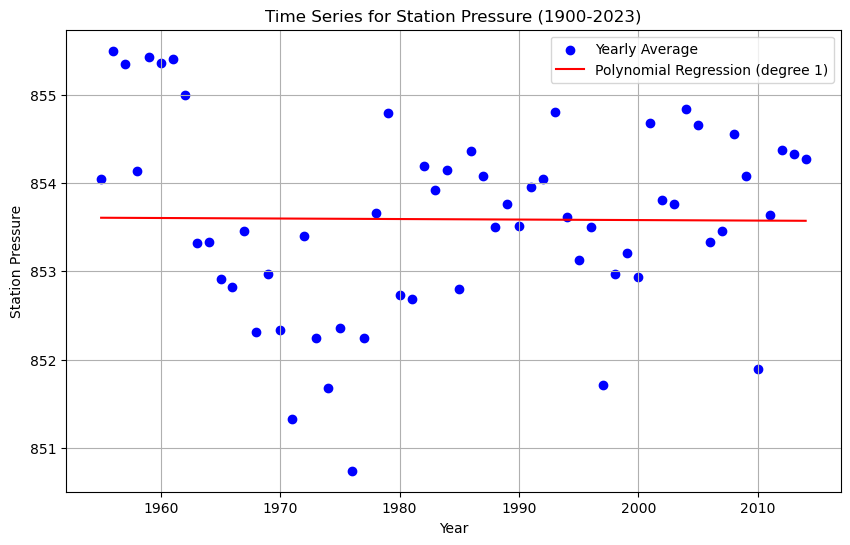

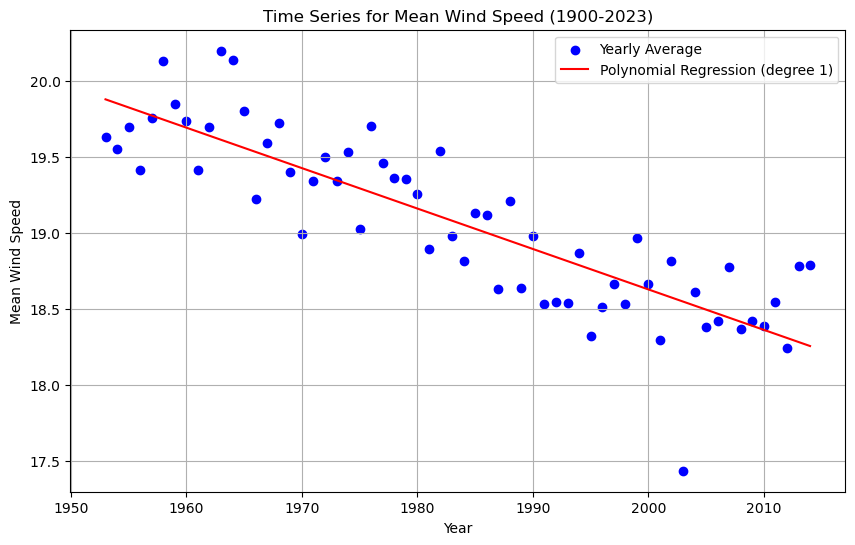

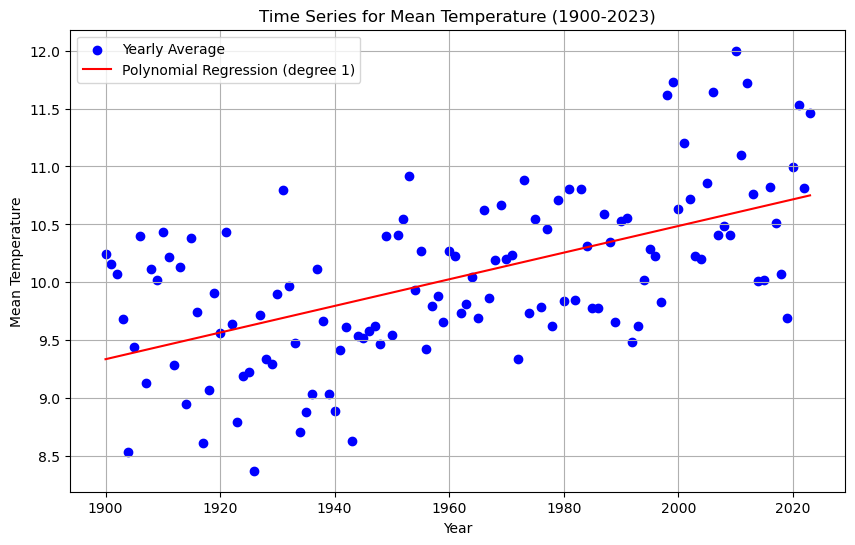

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

ecws_data = pd.read_csv('AHCCD_CONFINED.csv')
ecws_data['Year'] = pd.to_numeric(ecws_data['Year'], errors='coerce')#making sure year column is numeric (not string)
ecws_data = ecws_data.dropna(subset=['Year'])#dropping rows with NaN year

start_year = 1900
end_year = 2023

variable_types = ecws_data['Value Type'].unique()#list variable types

for var_type in variable_types:#create plot for each variable
    data_subset = ecws_data[ecws_data['Value Type'] == var_type]#filter for current type
    
    data_subset = data_subset[(data_subset['Year'] >= start_year) & (data_subset['Year'] <= end_year)]#filter for time span
    
    yearly_avg = data_subset.groupby('Year').mean(numeric_only=True).reset_index()#group by year and caluclate average

    X = yearly_avg['Year'].values.reshape(-1, 1)#extract year and average value across all stations for regression
    y = yearly_avg.iloc[:, 1:].mean(axis=1).values

    degree = 1#regression
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    model_poly = LinearRegression()
    model_poly.fit(X_poly, y)
    y_poly_pred = model_poly.predict(X_poly)

    plt.figure(figsize=(10, 6))#plotting
    plt.scatter(yearly_avg['Year'], y, label='Yearly Average', color='blue', marker='o')
    plt.plot(yearly_avg['Year'], y_poly_pred, label=f'Polynomial Regression (degree {degree})', color='red', linestyle='-')
    plt.title(f'Time Series for {var_type} ({start_year}-{end_year})')
    plt.xlabel('Year')
    plt.ylabel(var_type)
    plt.legend()
    plt.grid()
    plt.show()

### An attempt at interpolating using 'Thin Plate' interpolaion:

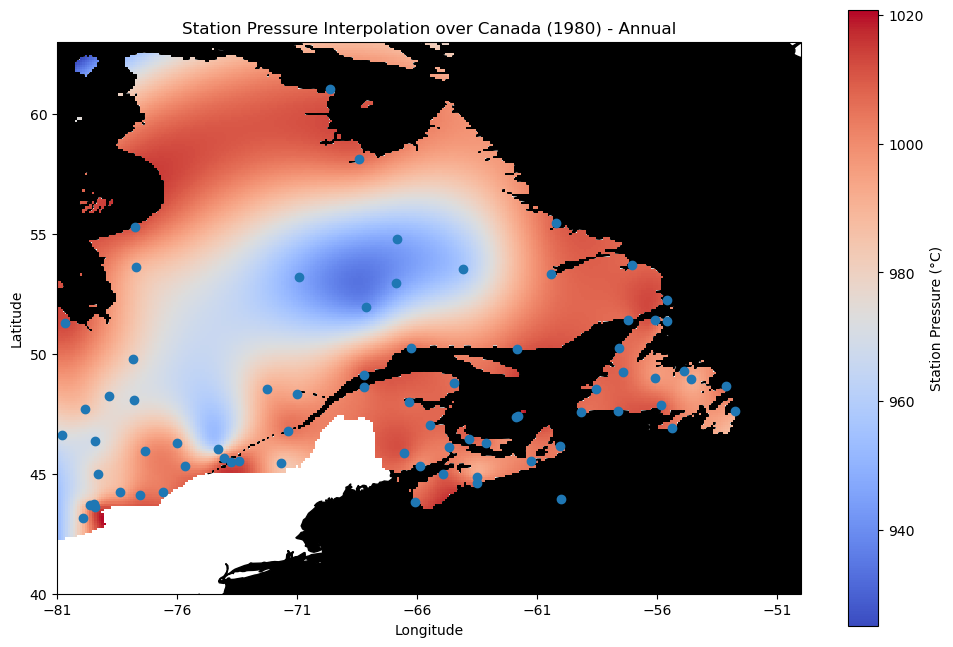

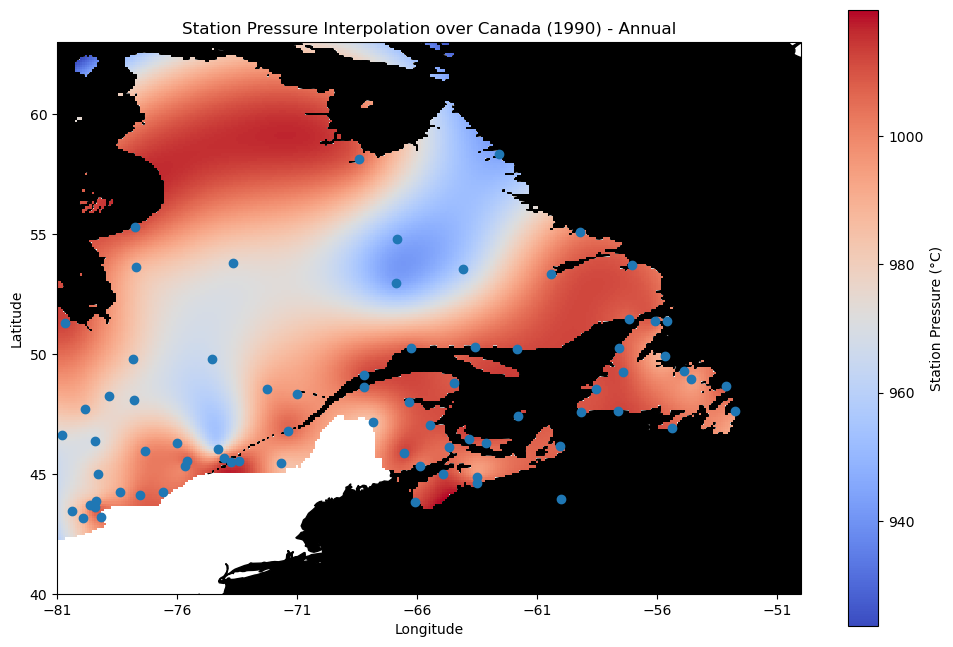

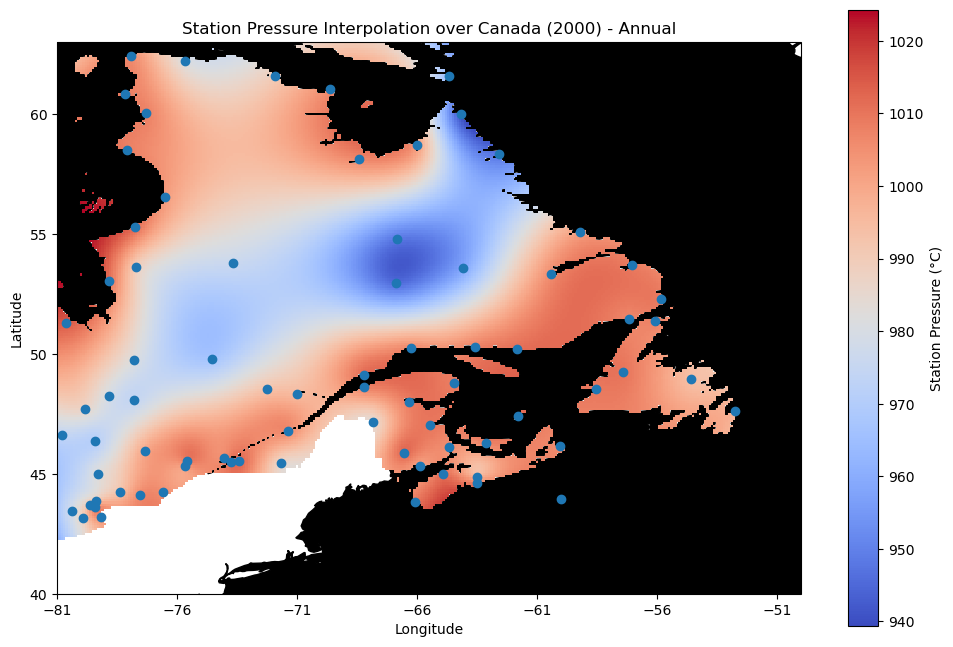

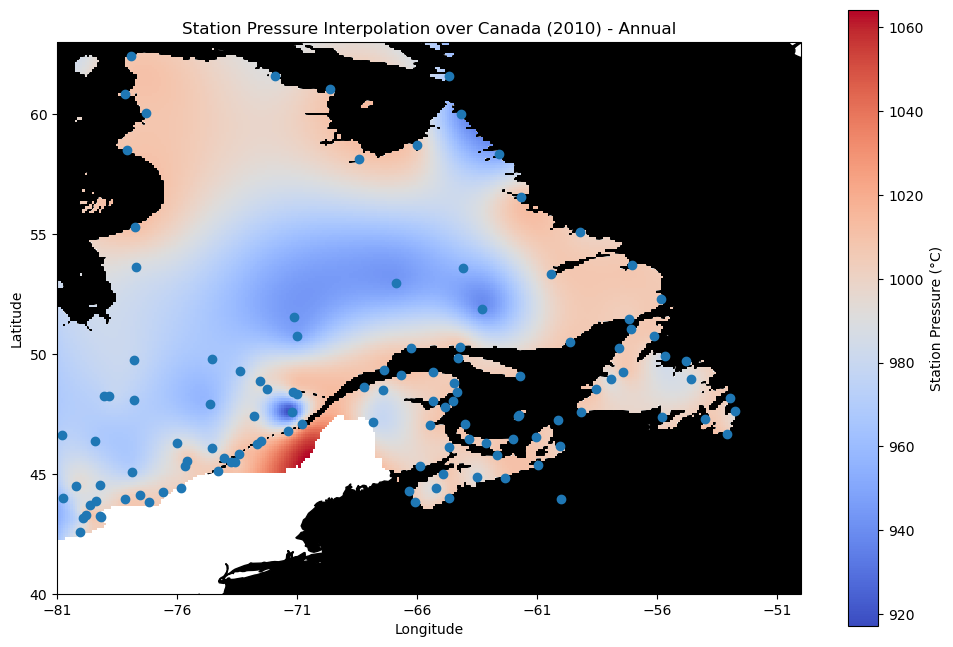

ValueError: zero-size array to reduction operation maximum which has no identity

In [54]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import Rbf
from shapely.geometry import Point
import cartopy.io.shapereader as shpreader

ecws_data = pd.read_csv('AHCCD_CONFINED.csv')

def plot_interpolated_data(value_type, year, columns):
    data_subset = ecws_data[(ecws_data['Value Type'] == value_type) & (ecws_data['Year'] == year)]#filter for specified value type and year
    data_subset = data_subset.drop_duplicates(subset=['Longitude', 'Latitude'])#removing duplicate coordinates

    ecws_lon = data_subset['Longitude'].values#extract coordinates
    ecws_lat = data_subset['Latitude'].values
    mean_values = data_subset[columns].mean(axis=1).values#average over the temporal specification ("columns")

    valid_indices = ~np.isnan(mean_values)#remove rows where mean is NaN
    ecws_lon = ecws_lon[valid_indices]
    ecws_lat = ecws_lat[valid_indices]
    mean_values = mean_values[valid_indices]

    lat_min, lat_max = 40, 63 #defining grid boundaries and resolution
    lon_min, lon_max = -81, -50
    lat_res, lon_res = 0.1, 0.1

    latitudes = np.arange(lat_min, lat_max, lat_res)#create array of coordinates
    longitudes = np.arange(lon_min, lon_max, lon_res)
    grid_lon, grid_lat = np.meshgrid(longitudes, latitudes)#mesh coordinates to create grid

    rbf_interpolator = Rbf(ecws_lon, ecws_lat, mean_values, function='thin_plate')#performing interpolation and creating interpolater object
    interpolated_grid = rbf_interpolator(grid_lon, grid_lat)#calling interpolater object and interpolating over given grid

    shape_reader = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')#accesses geometry of canada as specified resolution
    canada_shape = [record.geometry for record in shpreader.Reader(shape_reader).records() if record.attributes['NAME'] == 'Canada'][0]#iterates over each country’s record in the shapefile and filters for records and returns polygon of canada's shape

    mask = np.zeros(interpolated_grid.shape, dtype=bool)#masks data outside of canada
    for i in range(grid_lon.shape[0]):
        for j in range(grid_lon.shape[1]):#iterates through the 2D grid
            point = Point(grid_lon[i, j], grid_lat[i, j])#creates a shapely.geometry.Point object for the current grid point which represents the geographical location at for each cell in grid
            if not canada_shape.contains(point): #if point lies outside of defined canada shape, then masking is set to true
                mask[i, j] = True

    interpolated_grid = np.ma.array(interpolated_grid, mask=mask) #apply the dak to the inerpolated grid

    data_da = xr.DataArray(#create xarray data array from interpolated data and coords
        interpolated_grid,
        dims=("latitude", "longitude"),
        coords={"latitude": latitudes, "longitude": longitudes},
        name=f"{value_type}_interpolated"
    )
    data_da.attrs["description"] = f"{value_type} Interpolation over Canada (RBF Multiquadratic)"

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()}) #option to plot with cartopy
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    #ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')
    #ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    #ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='black')

    data_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': f'{value_type} (°C)'})#plotting intterpolated grid
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{value_type} Interpolation over Canada ({year}) - {', '.join(columns)}")
    plt.scatter(ecws_lon, ecws_lat)#alllows for plotting of stations where data has been used for interpolation
    plt.show()

plot_interpolated_data('Station Pressure', 1980, ['Annual'])
plot_interpolated_data('Station Pressure', 1990, ['Annual'])
plot_interpolated_data('Station Pressure', 2000, ['Annual'])
plot_interpolated_data('Station Pressure', 2010, ['Annual'])
plot_interpolated_data('Station Pressure', 2015, ['Annual'])



Yearly Average Pre-1997 Slope: 0.011544
Yearly Average Post-1997 Slope: 0.021284
Yearly Average Pre-1997 Z-Score: 2.073092
Yearly Average Post-1997 Z-Score: 1.152754
Percentage change in gradient from segment pre to post-1997: 45.76%
Yearly Average Total Gradient (Slope): 0.014396
Yearly Average Total Z-Score: 4.386518


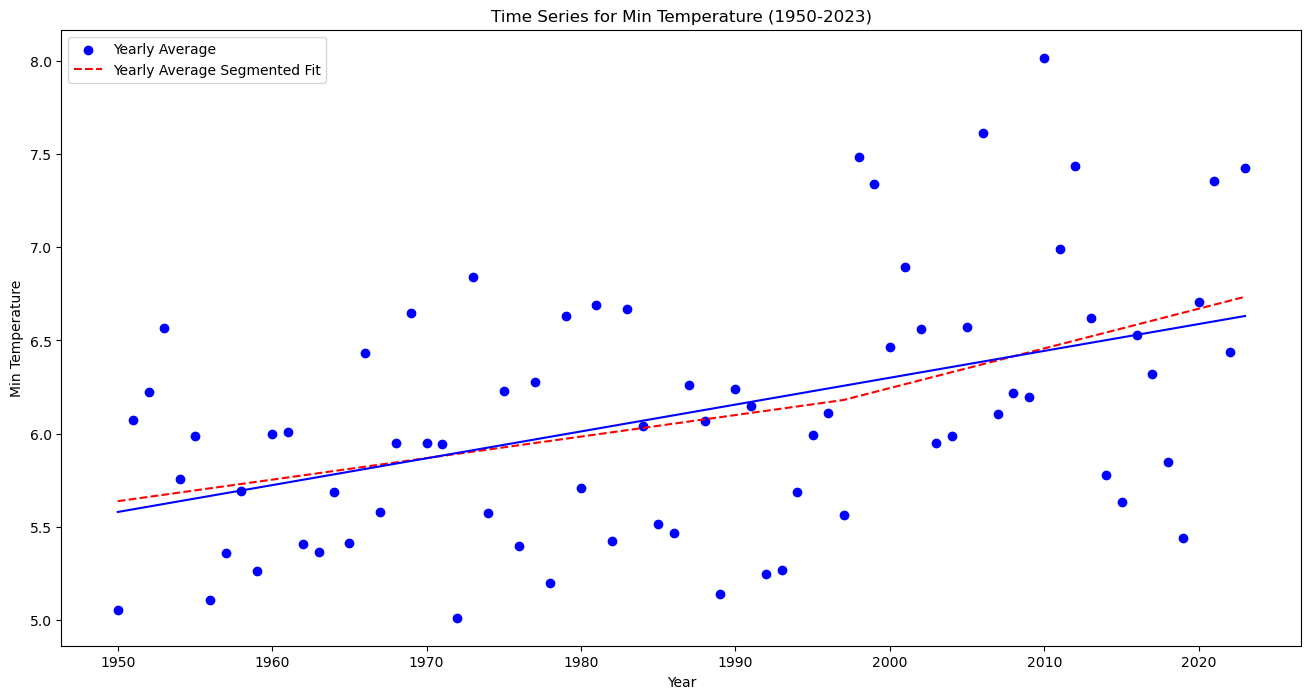

Yearly Average Pre-1997 Slope: 0.008688
Yearly Average Post-1997 Slope: 0.018667
Yearly Average Pre-1997 Z-Score: 1.969325
Yearly Average Post-1997 Z-Score: 1.140111
Percentage change in gradient from segment pre to post-1997: 53.46%
Yearly Average Total Gradient (Slope): 0.011610
Yearly Average Total Z-Score: 4.184297


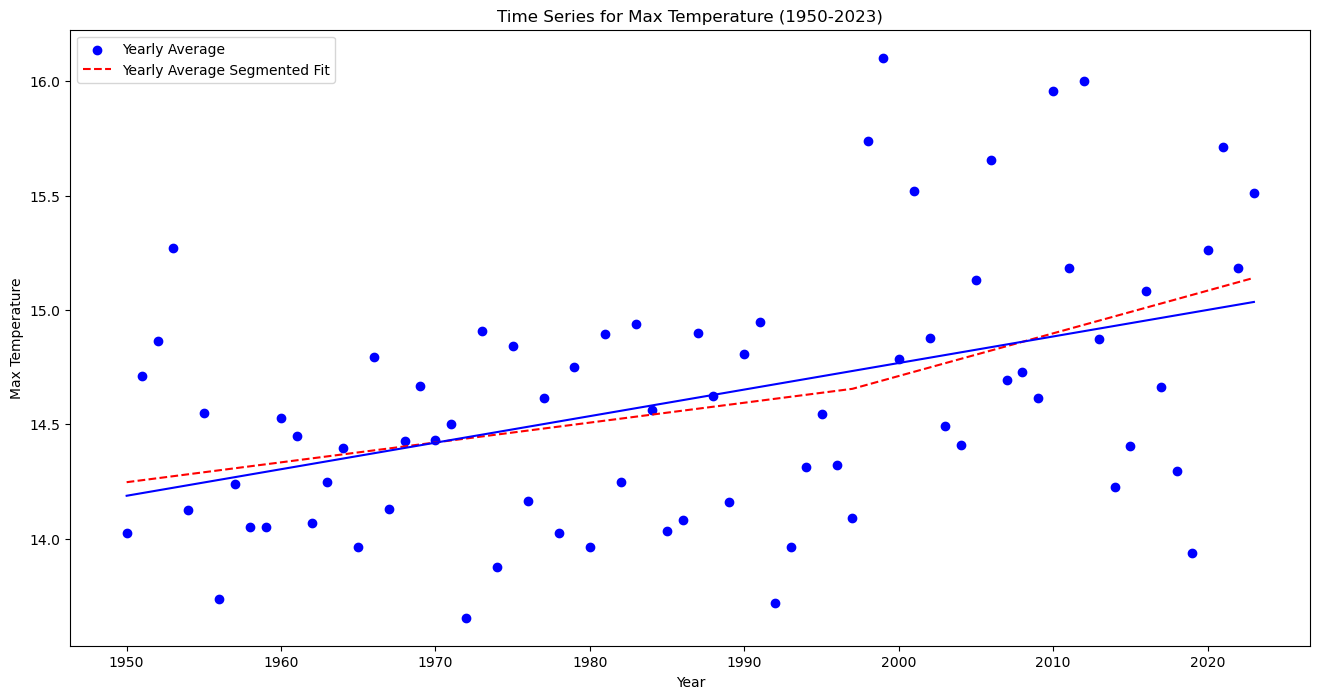

Yearly Average Pre-1997 Slope: 0.046549
Yearly Average Post-1997 Slope: -0.373282
Yearly Average Pre-1997 Z-Score: 0.724258
Yearly Average Post-1997 Z-Score: -1.650830
Percentage change in gradient from segment pre to post-1997: -112.47%
Yearly Average Total Gradient (Slope): -0.044879
Yearly Average Total Z-Score: -1.173658


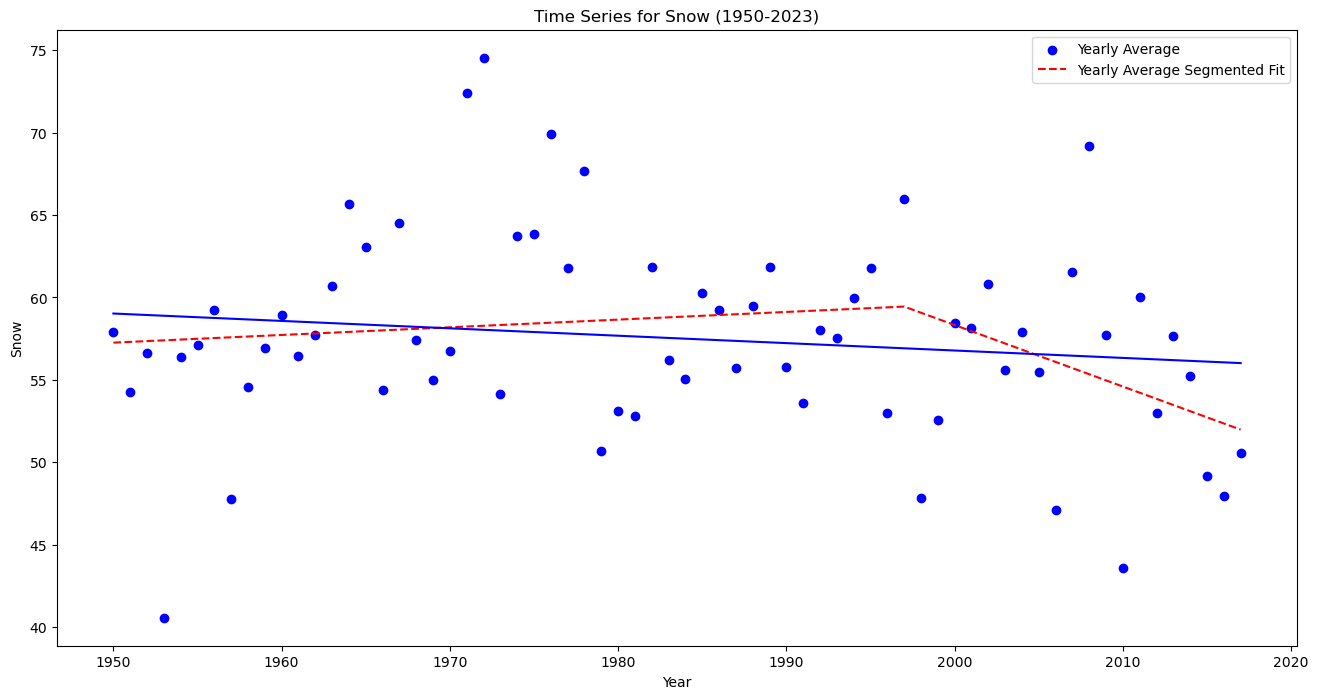

Yearly Average Pre-1997 Slope: 0.252602
Yearly Average Post-1997 Slope: 0.132208
Yearly Average Pre-1997 Z-Score: 2.264432
Yearly Average Post-1997 Z-Score: 0.325103
Percentage change in gradient from segment pre to post-1997: -91.06%
Yearly Average Total Gradient (Slope): 0.226383
Yearly Average Total Z-Score: 3.489692


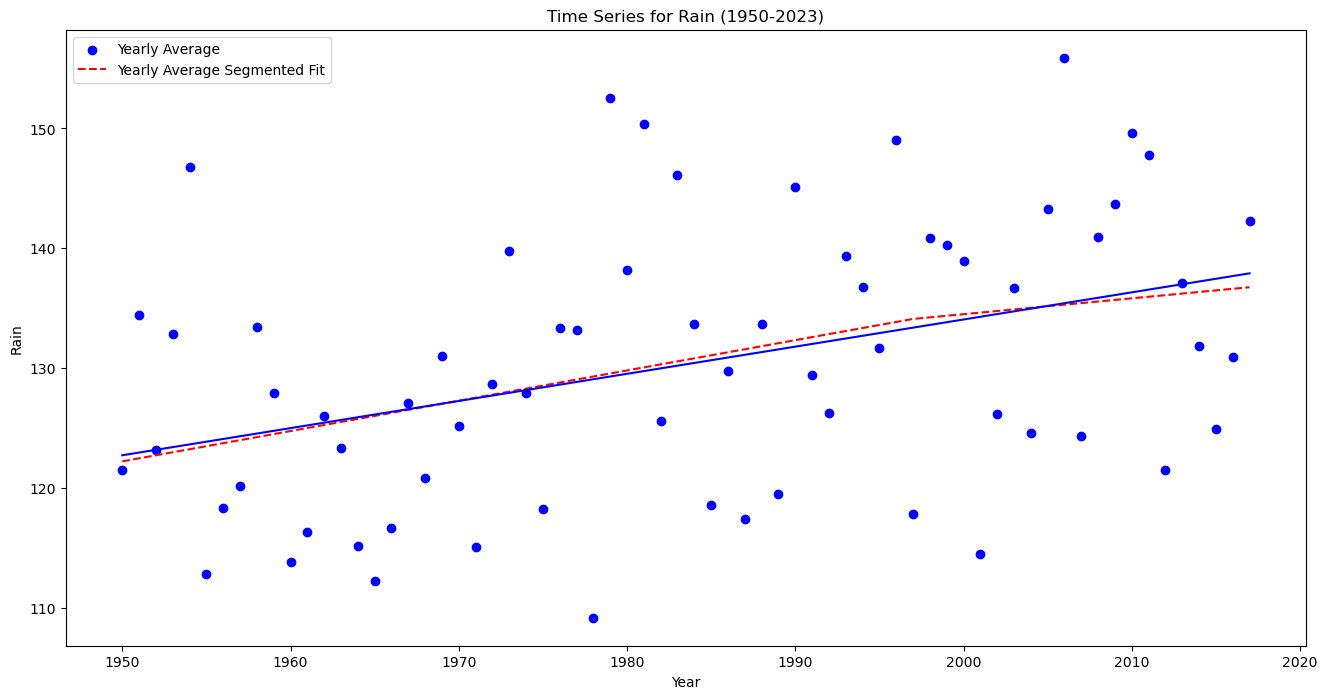

Yearly Average Pre-1997 Slope: 0.292133
Yearly Average Post-1997 Slope: -0.208189
Yearly Average Pre-1997 Z-Score: 2.902333
Yearly Average Post-1997 Z-Score: -0.535474
Percentage change in gradient from segment pre to post-1997: -240.32%
Yearly Average Total Gradient (Slope): 0.183176
Yearly Average Total Z-Score: 3.010937


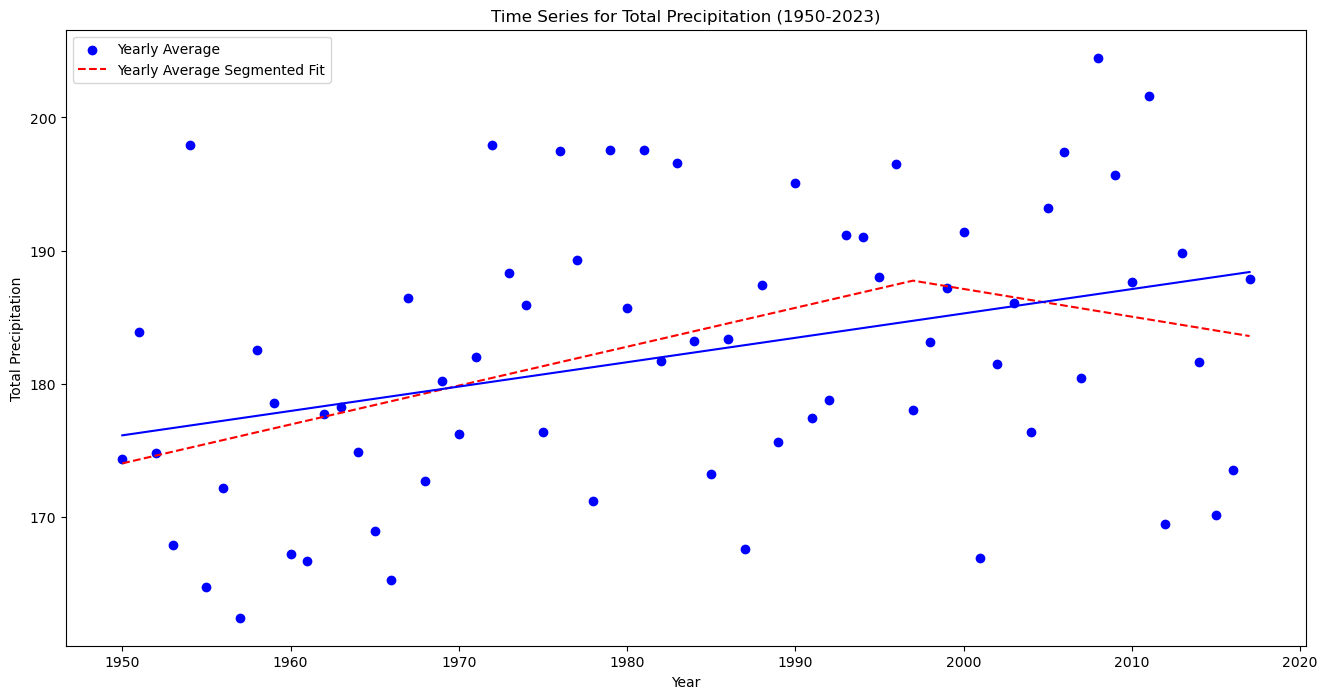

Yearly Average Pre-1997 Slope: 0.019753
Yearly Average Post-1997 Slope: -0.036924
Yearly Average Pre-1997 Z-Score: 2.493720
Yearly Average Post-1997 Z-Score: -1.121567
Percentage change in gradient from segment pre to post-1997: -153.50%
Yearly Average Total Gradient (Slope): 0.008108
Yearly Average Total Z-Score: 1.626623


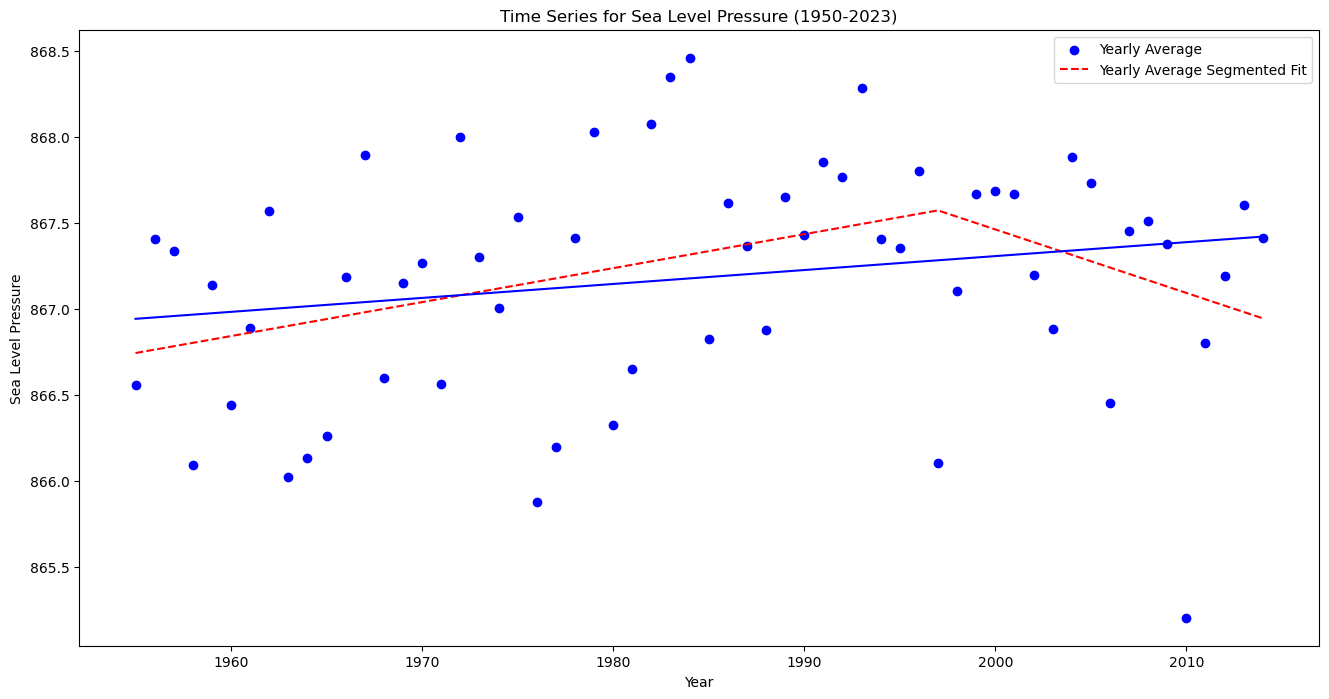

Yearly Average Pre-1997 Slope: -0.016518
Yearly Average Post-1997 Slope: 0.061023
Yearly Average Pre-1997 Z-Score: -1.144497
Yearly Average Post-1997 Z-Score: 1.550355
Percentage change in gradient from segment pre to post-1997: 127.07%
Yearly Average Total Gradient (Slope): -0.000585
Yearly Average Total Z-Score: -0.072873


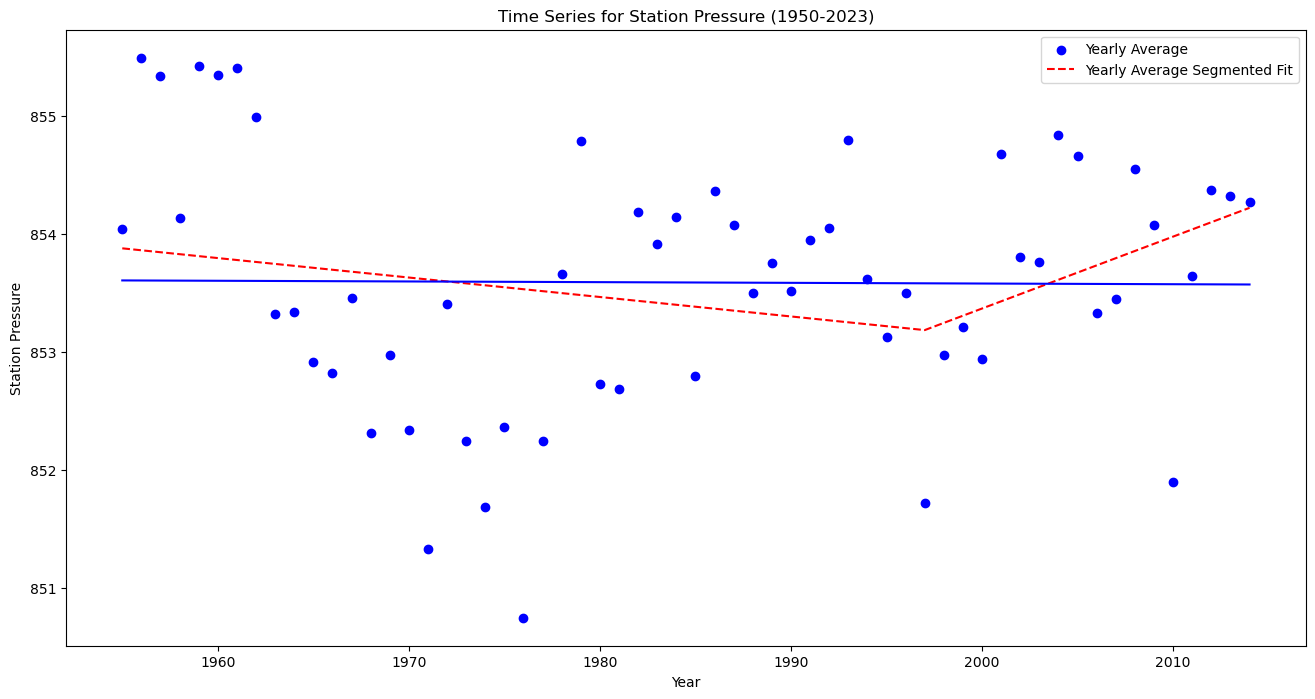

Yearly Average Pre-1997 Slope: -0.031191
Yearly Average Post-1997 Slope: -0.007623
Yearly Average Pre-1997 Z-Score: -9.670325
Yearly Average Post-1997 Z-Score: -0.480449
Percentage change in gradient from segment pre to post-1997: 309.15%
Yearly Average Total Gradient (Slope): -0.026620
Yearly Average Total Z-Score: -12.481948


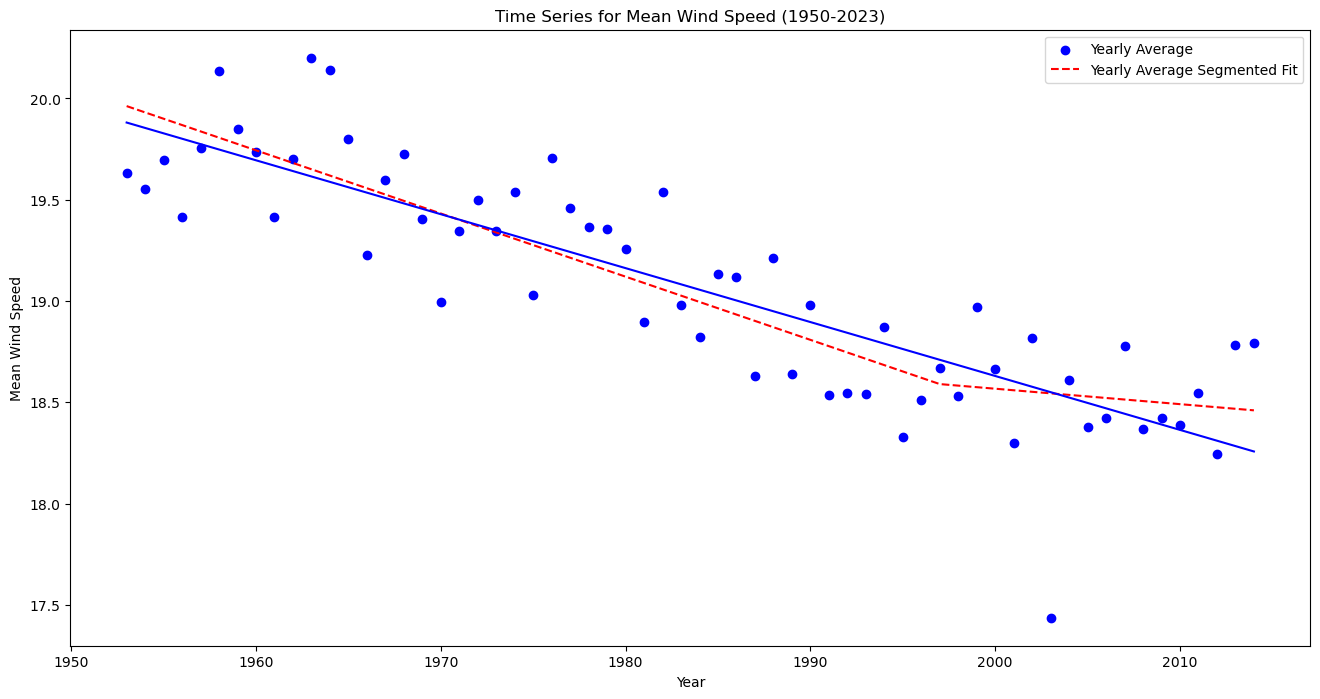

Yearly Average Pre-1997 Slope: 0.010216
Yearly Average Post-1997 Slope: 0.019871
Yearly Average Pre-1997 Z-Score: 2.094436
Yearly Average Post-1997 Z-Score: 1.152875
Percentage change in gradient from segment pre to post-1997: 48.59%
Yearly Average Total Gradient (Slope): 0.013043
Yearly Average Total Z-Score: 4.377928


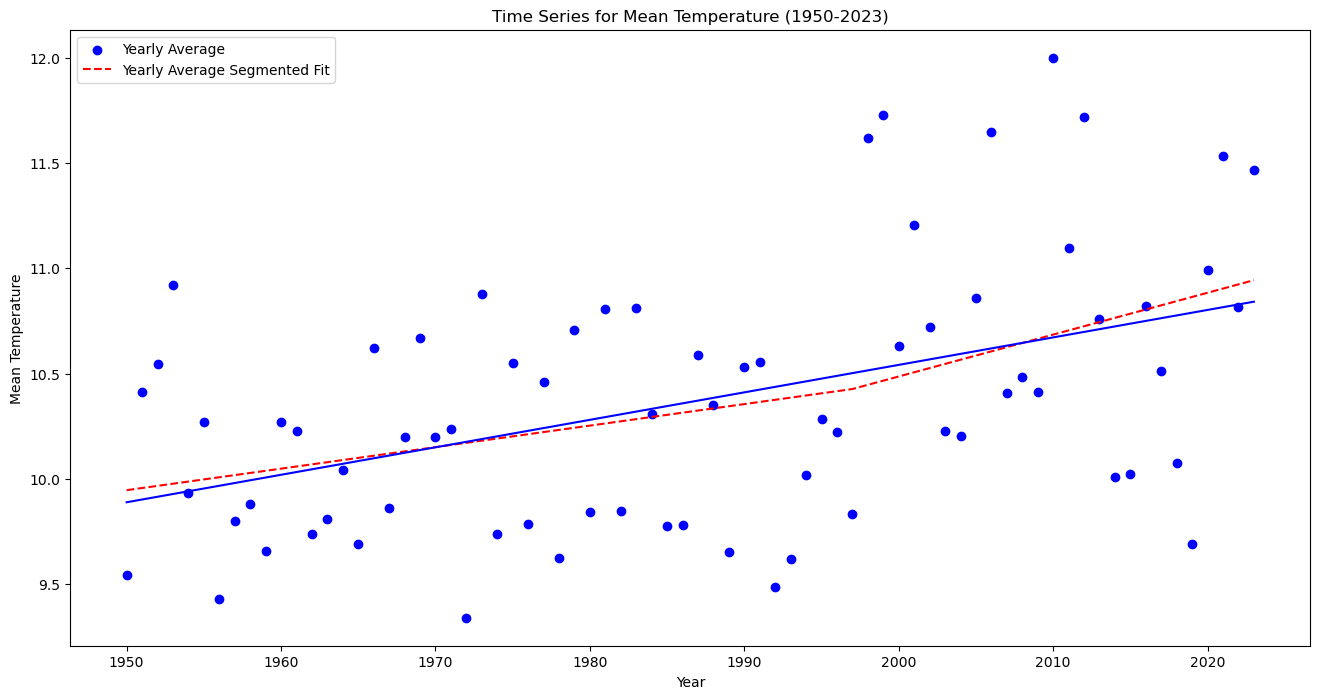

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

ecws_data = pd.read_csv('AHCCD_CONFINED.csv')
ecws_data['Year'] = pd.to_numeric(ecws_data['Year'], errors='coerce')
ecws_data = ecws_data.dropna(subset=['Year'])

start_year = 1950
end_year = 2023
split_year = 1997

variable_types = ecws_data['Value Type'].unique()

def piecewise_linear_fixed_split(x, slope1, intercept1, slope2):#defining piecewise linear model
    return np.where(x < split_year, slope1 * x + intercept1, slope2 * (x - split_year) + (slope1 * split_year + intercept1))

def plot_with_piecewise_regression(time, data, color, label):#function to plot with segmented regression
    p0 = [0.1, np.mean(data), 0.1]
    params, _ = curve_fit(piecewise_linear_fixed_split, time, data, p0, maxfev=10000)
    slope1, intercept1, slope2 = params
    y_fit = piecewise_linear_fixed_split(time, slope1, intercept1, slope2)
    plt.scatter(time, data, color=color, label=label)#plotting
    plt.plot(time, y_fit, color='red', linestyle='--', label=f'{label} Segmented Fit')
    print(f"{label} Pre-{split_year} Slope: {slope1:.6f}")
    print(f"{label} Post-{split_year} Slope: {slope2:.6f}")
    #z-scores
    pre_indices = time < split_year
    post_indices = time >= split_year
    residuals_pre = data[pre_indices] - (slope1 * time[pre_indices] + intercept1)
    residuals_post = data[post_indices] - (slope2 * (time[post_indices] - split_year) + (slope1 * split_year + intercept1))
    s_err_pre = np.sqrt(np.sum(residuals_pre**2) / (len(time[pre_indices]) - 2))
    s_err_post = np.sqrt(np.sum(residuals_post**2) / (len(time[post_indices]) - 2))
    x_mean_pre = np.mean(time[pre_indices])
    x_mean_post = np.mean(time[post_indices])
    se_slope_pre = s_err_pre / np.sqrt(np.sum((time[pre_indices] - x_mean_pre)**2))
    se_slope_post = s_err_post / np.sqrt(np.sum((time[post_indices] - x_mean_post)**2))
    z_score_pre = slope1 / se_slope_pre
    z_score_post = slope2 / se_slope_post

    print(f"{label} Pre-{split_year} Z-Score: {z_score_pre:.6f}")
    print(f"{label} Post-{split_year} Z-Score: {z_score_post:.6f}")

    percentage_change = ((slope2 - slope1) / abs(slope2) * 100)
    print(f"Percentage change in gradient from segment pre to post-{split_year}: {percentage_change:.2f}%")

    coeffs_total = np.polyfit(time, data, 1) #fitting entire dataset
    slope_total, intercept_total = coeffs_total
    y_fit_total = np.polyval(coeffs_total, time)
    plt.plot(time, y_fit_total, color=color, linestyle='-', linewidth=1.5)
    residuals_total = data - y_fit_total
    N_total = len(time)
    s_err_total = np.sqrt(np.sum(residuals_total**2) / (N_total - 2))
    x_mean_total = np.mean(time)
    se_slope_total = s_err_total / np.sqrt(np.sum((time - x_mean_total)**2))
    z_score_total = slope_total / se_slope_total
    print(f"{label} Total Gradient (Slope): {slope_total:.6f}")
    print(f"{label} Total Z-Score: {z_score_total:.6f}")

    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Data Value")
    plt.title(f"{label} with Piecewise Regression")

for var_type in variable_types:#iterate over variable types
    data_subset = ecws_data[ecws_data['Value Type'] == var_type]
    data_subset = data_subset[(data_subset['Year'] >= start_year) & (data_subset['Year'] <= end_year)]
    
    yearly_avg = data_subset.groupby('Year').mean(numeric_only=True).reset_index()
    X = yearly_avg['Year'].values
    y = yearly_avg.iloc[:, 1:].mean(axis=1).values
    
    plt.figure(figsize=(16, 8))
    plot_with_piecewise_regression(X, y, 'blue', 'Yearly Average')
    
    plt.title(f'Time Series for {var_type} ({start_year}-{end_year})')
    plt.xlabel('Year')
    plt.ylabel(var_type)
    plt.legend()
    #plt.grid()
    plt.show()


East Temperature Pre-1997 Slope: -0.00038931, Z-Score: -0.23239808
East Temperature Post-1997 Slope: 0.04289401, Z-Score: 2.22967811
East Temperature Total Slope: 0.00346752, Z-Score: 2.56568239
East Temperature Percentage Change in Gradient: 100.91%
West Temperature Pre-1997 Slope: -0.00491171, Z-Score: -2.51264217
West Temperature Post-1997 Slope: 0.04618789, Z-Score: 1.99327666
West Temperature Total Slope: -0.00035840, Z-Score: -0.22526853
West Temperature Percentage Change in Gradient: 110.63%
Overall Temperature Pre-1997 Slope: -0.00291404, Z-Score: -1.74069029
Overall Temperature Post-1997 Slope: 0.04473086, Z-Score: 2.17010759
Overall Temperature Total Slope: 0.00133143, Z-Score: 0.95931241
Overall Temperature Percentage Change in Gradient: 106.51%


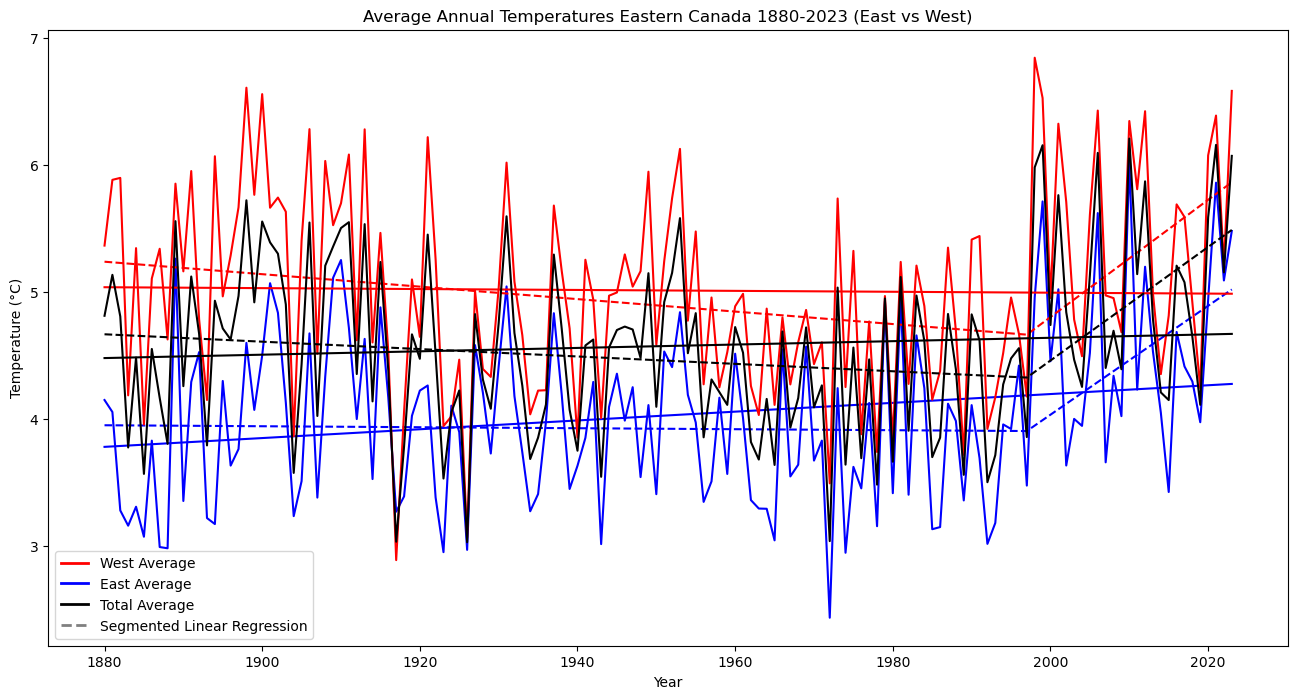

North Temperature Pre-1997 Slope: 0.00278820, Z-Score: 1.60798333
North Temperature Post-1997 Slope: 0.03651779, Z-Score: 1.68517652
North Temperature Total Slope: 0.00579373, Z-Score: 4.13965813
North Temperature Percentage Change in Gradient: 92.36%
South Temperature Pre-1997 Slope: 0.00603830, Z-Score: 3.50577123
South Temperature Post-1997 Slope: 0.04496976, Z-Score: 2.35869567
South Temperature Total Slope: 0.00950735, Z-Score: 6.98149403
South Temperature Percentage Change in Gradient: 86.57%
Overall Temperature Pre-1997 Slope: -0.00291404, Z-Score: -1.74069029
Overall Temperature Post-1997 Slope: 0.04473086, Z-Score: 2.17010759
Overall Temperature Total Slope: 0.00133143, Z-Score: 0.95931241
Overall Temperature Percentage Change in Gradient: 106.51%


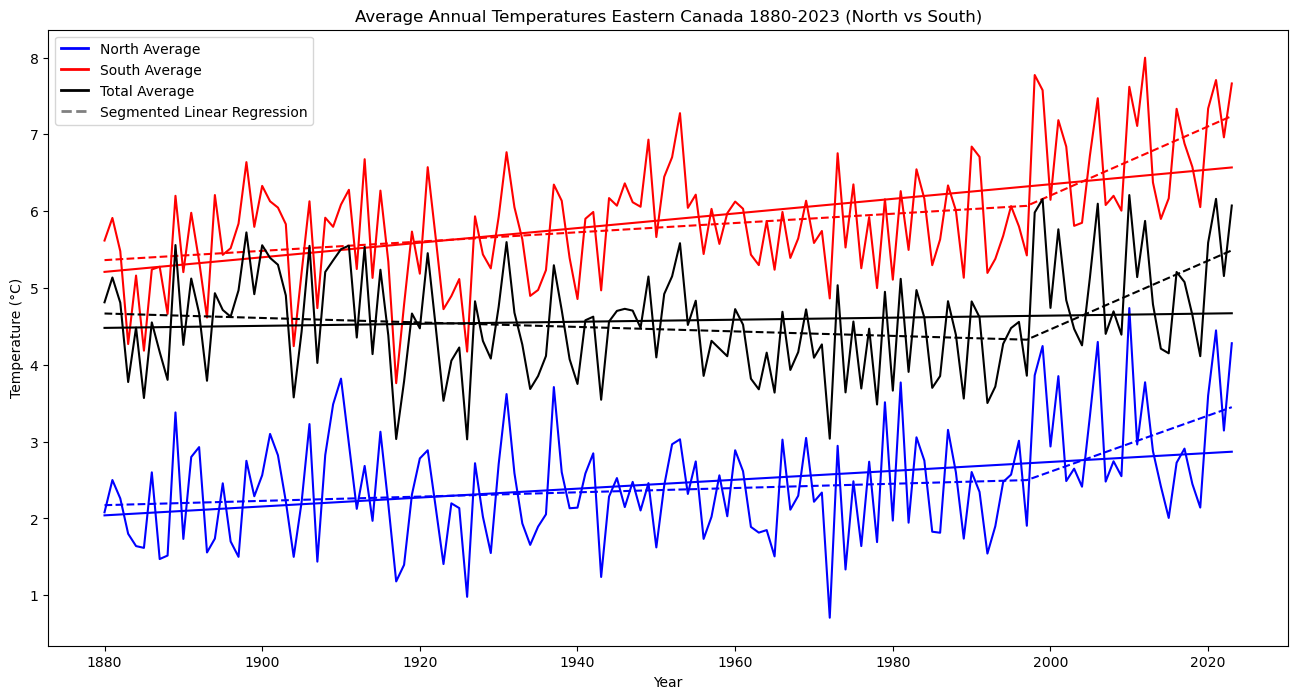

Winter Pre-1997 Slope: -0.00889067, Z-Score: -2.16933198
Winter Post-1997 Slope: 0.07696469, Z-Score: 1.76270056
Winter Total Slope: -0.00124039, Z-Score: -0.38821826
Winter Percentage Change in Gradient: 111.55%
Spring Pre-1997 Slope: 0.00128537, Z-Score: 0.43479767
Spring Post-1997 Slope: 0.01106087, Z-Score: 0.33760249
Spring Total Slope: 0.00215642, Z-Score: 0.95965444
Spring Percentage Change in Gradient: 88.38%
Summer Pre-1997 Slope: 0.00053415, Z-Score: 0.28704720
Summer Post-1997 Slope: 0.03357473, Z-Score: 2.42032713
Summer Total Slope: 0.00347828, Z-Score: 2.57032543
Summer Percentage Change in Gradient: 98.41%
Autumn Pre-1997 Slope: -0.00398928, Z-Score: -1.81358645
Autumn Post-1997 Slope: 0.04975660, Z-Score: 2.39295037
Autumn Total Slope: 0.00079983, Z-Score: 0.47143852
Autumn Percentage Change in Gradient: 108.02%


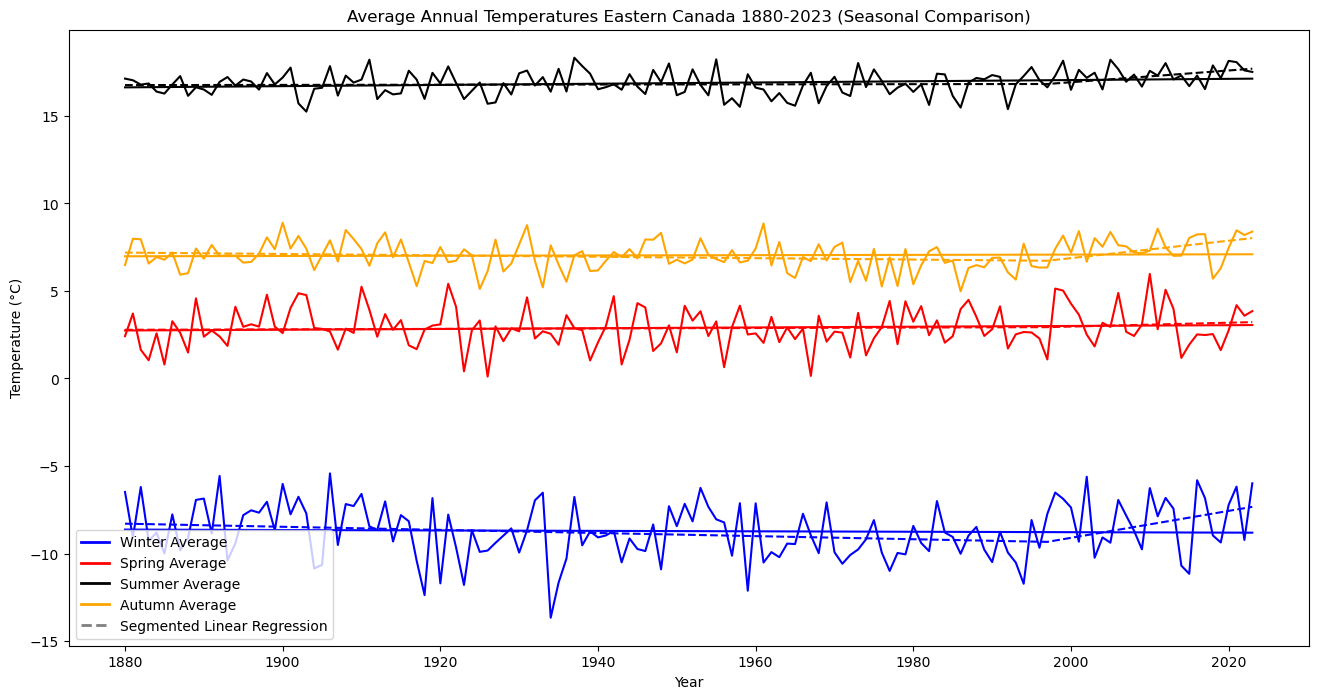

East Rainfall Pre-1997 Slope: -0.83635657, Z-Score: -3.03536846
East Rainfall Post-1997 Slope: 3.28893614, Z-Score: 0.93795100
East Rainfall Total Slope: -0.59043407, Z-Score: -2.74768343
East Rainfall Percentage Change in Gradient: 125.43%
West Rainfall Pre-1997 Slope: 0.60202884, Z-Score: 3.50136899
West Rainfall Post-1997 Slope: 5.81472235, Z-Score: 1.99736134
West Rainfall Total Slope: 0.91277507, Z-Score: 6.29658037
West Rainfall Percentage Change in Gradient: 89.65%
Overall Rainfall Pre-1997 Slope: -0.18326462, Z-Score: -0.89469076
Overall Rainfall Post-1997 Slope: 3.86405746, Z-Score: 1.33760546
Overall Rainfall Total Slope: 0.05800993, Z-Score: 0.35504670
Overall Rainfall Percentage Change in Gradient: 104.74%


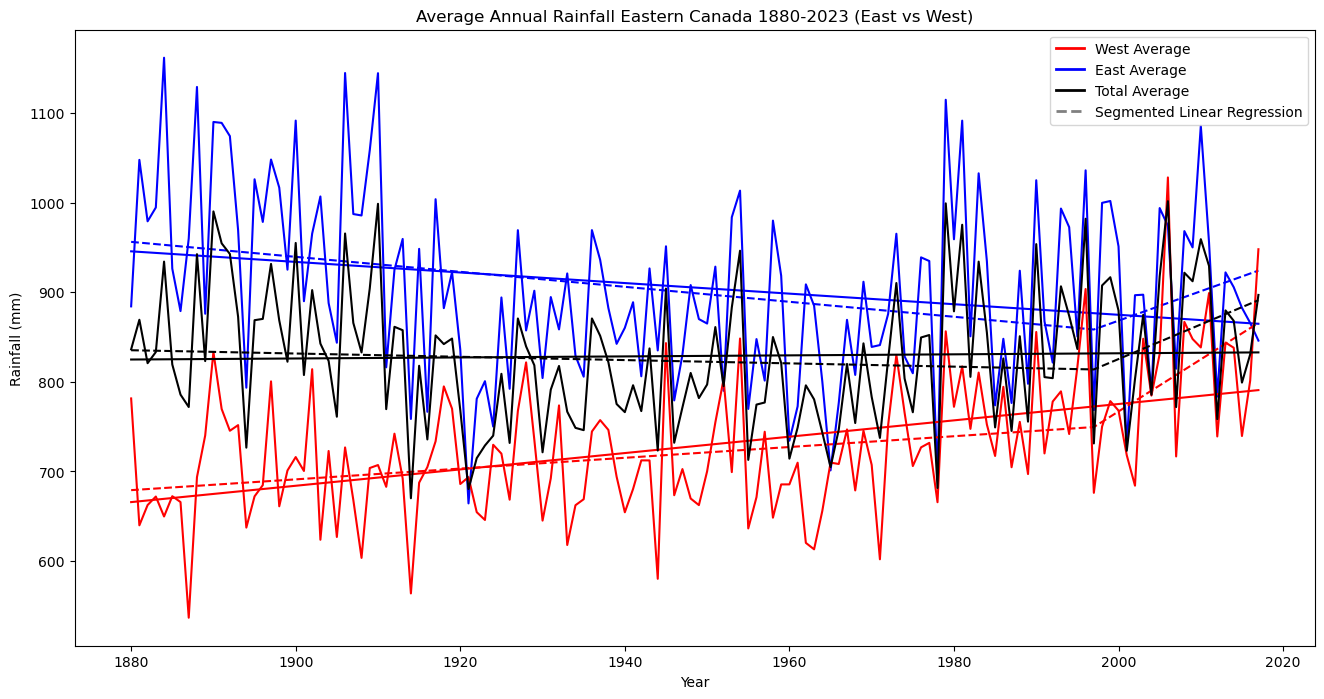

North Rainfall Pre-1997 Slope: -0.02918806, Z-Score: -0.13317875
North Rainfall Post-1997 Slope: 1.49845354, Z-Score: 0.55997829
North Rainfall Total Slope: 0.06187984, Z-Score: 0.36713595
North Rainfall Percentage Change in Gradient: 101.95%
South Rainfall Pre-1997 Slope: 0.64880544, Z-Score: 2.64736409
South Rainfall Post-1997 Slope: 1.64031659, Z-Score: 0.42887816
South Rainfall Total Slope: 0.70791270, Z-Score: 3.62224078
South Rainfall Percentage Change in Gradient: 60.45%
Overall Rainfall Pre-1997 Slope: -0.18326462, Z-Score: -0.89469076
Overall Rainfall Post-1997 Slope: 3.86405746, Z-Score: 1.33760546
Overall Rainfall Total Slope: 0.05800993, Z-Score: 0.35504670
Overall Rainfall Percentage Change in Gradient: 104.74%


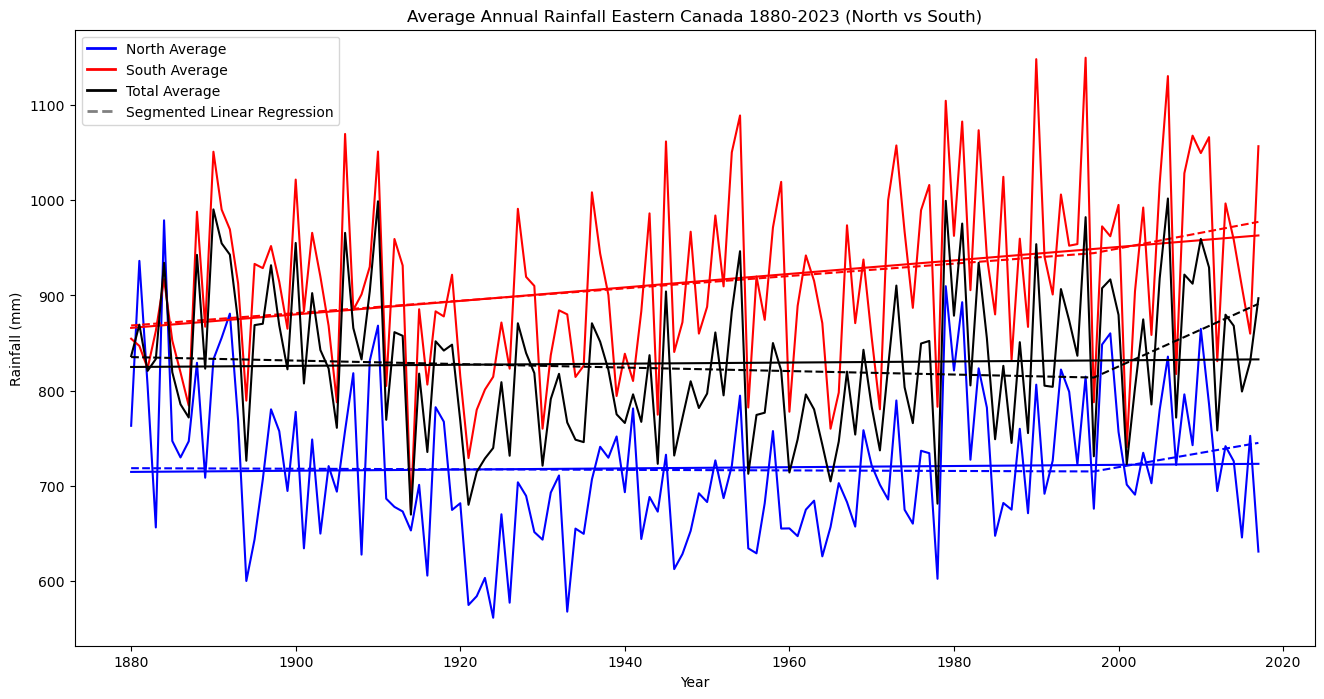

Winter Pre-1997 Slope: -0.26235444, Z-Score: -3.16932182
Winter Post-1997 Slope: 0.34333734, Z-Score: 0.38063422
Winter Total Slope: -0.22624710, Z-Score: -3.59865147
Winter Percentage Change in Gradient: 176.41%
Spring Pre-1997 Slope: -0.07199227, Z-Score: -0.74362883
Spring Post-1997 Slope: 1.26582276, Z-Score: 1.04319665
Spring Total Slope: 0.00775935, Z-Score: 0.10314172
Spring Percentage Change in Gradient: 105.69%
Summer Pre-1997 Slope: 0.16811826, Z-Score: 1.95586062
Summer Post-1997 Slope: 1.50711950, Z-Score: 1.50726252
Summer Total Slope: 0.24794062, Z-Score: 3.73565176
Summer Percentage Change in Gradient: 88.85%
Autumn Pre-1997 Slope: 0.12059279, Z-Score: 1.19554835
Autumn Post-1997 Slope: 1.21141589, Z-Score: 0.79859129
Autumn Total Slope: 0.18562040, Z-Score: 2.31229678
Autumn Percentage Change in Gradient: 90.05%


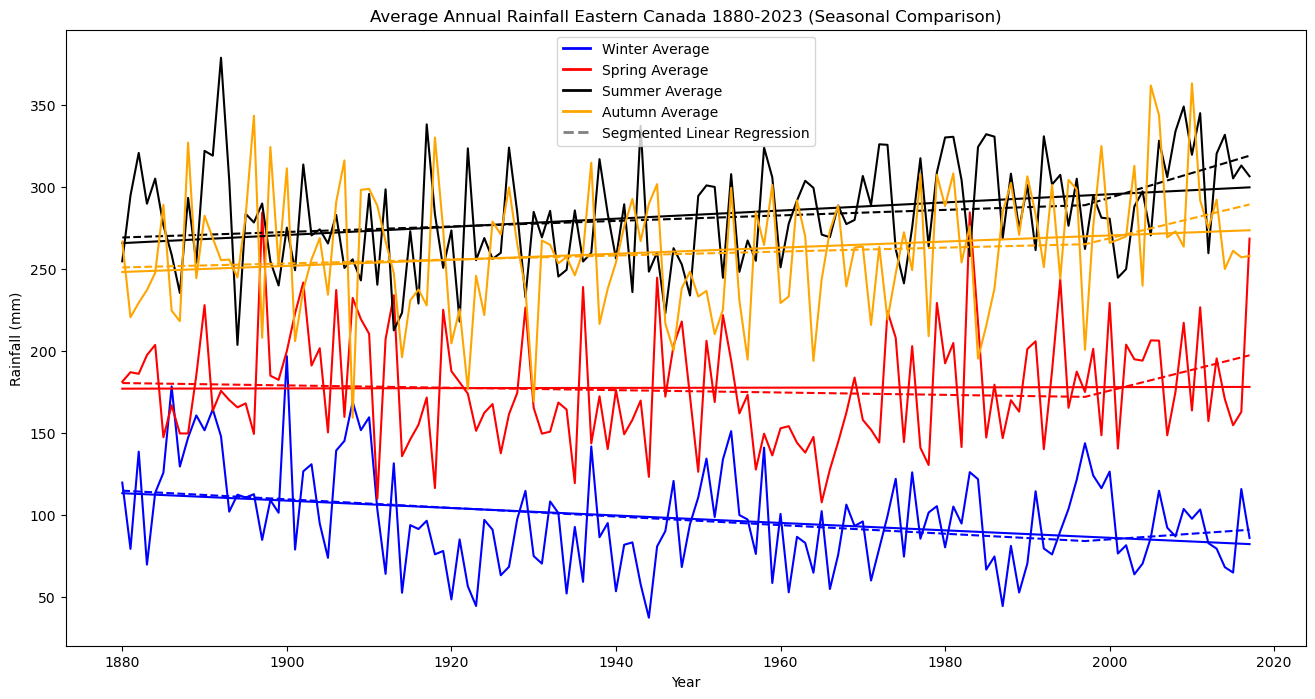

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

file_path = 'AHCCD_CONFINED.csv'
ecws_data = pd.read_csv(file_path)

start_year = 1880
end_year = 2023
split_year = 1997

ecws_data = ecws_data[(ecws_data['Year'] >= start_year) & (ecws_data['Year'] <= end_year)]#fillter for time range

lat_split = ecws_data['Latitude'].median()#N/S/E/W segregation
lon_split = ecws_data['Longitude'].median()
ecws_data['Region'] = np.where(ecws_data['Latitude'] > lat_split, 'North', 'South')
ecws_data['Region'] += np.where(ecws_data['Longitude'] > lon_split, ' East', ' West')

def piecewise_linear_fixed_split(x, slope1, intercept1, slope2):#piecewise func
    return np.where(x < split_year, slope1 * x + intercept1, slope2 * (x - split_year) + (slope1 * split_year + intercept1))

def plot_with_fits(time, data, label, color, ax, linestyle='--'):
    time, data = time[~np.isnan(data)], data[~np.isnan(data)]#remove nans

    params, _ = curve_fit(piecewise_linear_fixed_split, time, data, [0.1, np.mean(data), 0.1], maxfev=10000)#piecewise linear fit
    slope1, intercept1, slope2 = params
    y_piecewise = piecewise_linear_fixed_split(time, slope1, intercept1, slope2)

    slope_total, intercept_total = np.polyfit(time, data, 1)#overall linear fit
    y_total = np.polyval([slope_total, intercept_total], time)

    ax.plot(time, data, label=label, color=color)  #datapoinits
    ax.plot(time, y_piecewise, linestyle=linestyle, color=color)  #piecewise fit
    ax.plot(time, y_total, '-', color=color)  #overall fit

    #z-scores
    pre_mask = time < split_year
    post_mask = time >= split_year
    residuals_pre = data[pre_mask] - (slope1 * time[pre_mask] + intercept1)
    residuals_post = data[post_mask] - (slope2 * (time[post_mask] - split_year) + (slope1 * split_year + intercept1))
    residuals_total = data - y_total

    s_err_pre = np.sqrt(np.sum(residuals_pre**2) / (len(time[pre_mask]) - 2))
    s_err_post = np.sqrt(np.sum(residuals_post**2) / (len(time[post_mask]) - 2))
    s_err_total = np.sqrt(np.sum(residuals_total**2) / (len(time) - 2))

    x_mean_pre = np.mean(time[pre_mask])
    x_mean_post = np.mean(time[post_mask])
    x_mean_total = np.mean(time)

    se_slope_pre = s_err_pre / np.sqrt(np.sum((time[pre_mask] - x_mean_pre)**2))
    se_slope_post = s_err_post / np.sqrt(np.sum((time[post_mask] - x_mean_post)**2))
    se_slope_total = s_err_total / np.sqrt(np.sum((time - x_mean_total)**2))

    z_score_pre = slope1 / se_slope_pre
    z_score_post = slope2 / se_slope_post
    z_score_total = slope_total / se_slope_total

    percentage_change = ((slope2 - slope1) / abs(slope2) * 100)
    print(f"{label} Pre-{split_year} Slope: {slope1:.8f}, Z-Score: {z_score_pre:.8f}")
    print(f"{label} Post-{split_year} Slope: {slope2:.8f}, Z-Score: {z_score_post:.8f}")
    print(f"{label} Total Slope: {slope_total:.8f}, Z-Score: {z_score_total:.8f}")
    print(f"{label} Percentage Change in Gradient: {percentage_change:.2f}%")

#clours for plots
colours = ['blue', 'red', 'black', 'orange']

#T E/W
fig, ax = plt.subplots(figsize=(16, 8))
temperature_data = ecws_data[ecws_data['Value Type'] == 'Mean Temperature']

for region, color in zip(['East', 'West'], colours[:2]):
    region_data = temperature_data[temperature_data['Region'].str.contains(region)]
    yearly_avg = region_data.groupby('Year')['Annual'].mean().reset_index()
    plot_with_fits(yearly_avg['Year'].values, yearly_avg['Annual'].values, f"{region} Temperature", color, ax)

overall_avg = temperature_data.groupby('Year')['Annual'].mean().reset_index()
plot_with_fits(overall_avg['Year'].values, overall_avg['Annual'].values, "Overall Temperature", colours[2], ax)
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Average Annual Temperatures Eastern Canada 1880-2023 (East vs West)")
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='West Average'),
    Line2D([0], [0], color='blue', lw=2, label='East Average'),
    Line2D([0], [0], color='black', lw=2, label='Total Average'),
    Line2D([0], [0], color='gray', linestyle='--', lw=2, label='Segmented Linear Regression'),
]
plt.legend(handles=legend_elements)
plt.show()

#T N/S
fig, ax = plt.subplots(figsize=(16, 8))
for region, color in zip(['North', 'South'], colours[:2]):
    region_data = temperature_data[temperature_data['Region'].str.contains(region)]
    yearly_avg = region_data.groupby('Year')['Annual'].mean().reset_index()
    plot_with_fits(yearly_avg['Year'].values, yearly_avg['Annual'].values, f"{region} Temperature", color, ax)

plot_with_fits(overall_avg['Year'].values, overall_avg['Annual'].values, "Overall Temperature", colours[2], ax)
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Average Annual Temperatures Eastern Canada 1880-2023 (North vs South)")
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='North Average'),
    Line2D([0], [0], color='red', lw=2, label='South Average'),
    Line2D([0], [0], color='black', lw=2, label='Total Average'),
    Line2D([0], [0], color='gray', linestyle='--', lw=2, label='Segmented Linear Regression'),
]
plt.legend(handles=legend_elements)
plt.show()

#T SA
fig, ax = plt.subplots(figsize=(16, 8))
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season, color in zip(seasons, colours):
    seasonal_avg = temperature_data.groupby('Year')[season].mean().reset_index()
    plot_with_fits(seasonal_avg['Year'].values, seasonal_avg[season].values, season, color, ax)
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Winter Average'),
    Line2D([0], [0], color='red', lw=2, label='Spring Average'),
    Line2D([0], [0], color='black', lw=2, label='Summer Average'),
    Line2D([0], [0], color='orange', lw=2, label='Autumn Average'),
    Line2D([0], [0], color='gray', linestyle='--', lw=2, label='Segmented Linear Regression'),
]
plt.legend(handles=legend_elements)
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Average Annual Temperatures Eastern Canada 1880-2023 (Seasonal Comparison)")

plt.show()

#R E/W
fig, ax = plt.subplots(figsize=(16, 8))
rainfall_data = ecws_data[ecws_data['Value Type'] == 'Rain']

for region, color in zip(['East', 'West'], colours[:2]):
    region_data = rainfall_data[rainfall_data['Region'].str.contains(region)]
    yearly_avg = region_data.groupby('Year')['Annual'].mean().reset_index()
    plot_with_fits(yearly_avg['Year'].values, yearly_avg['Annual'].values, f"{region} Rainfall", color, ax)

overall_avg = rainfall_data.groupby('Year')['Annual'].mean().reset_index()
plot_with_fits(overall_avg['Year'].values, overall_avg['Annual'].values, "Overall Rainfall", colours[2], ax)
ax.set_xlabel("Year")
ax.set_ylabel("Rainfall (mm)")
ax.set_title("Average Annual Rainfall Eastern Canada 1880-2023 (East vs West)")
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='West Average'),
    Line2D([0], [0], color='blue', lw=2, label='East Average'),
    Line2D([0], [0], color='black', lw=2, label='Total Average'),
    Line2D([0], [0], color='gray', linestyle='--', lw=2, label='Segmented Linear Regression'),
]
plt.legend(handles=legend_elements)
plt.show()

#R N/S
fig, ax = plt.subplots(figsize=(16, 8))
for region, color in zip(['North', 'South'], colours[:2]):
    region_data = rainfall_data[rainfall_data['Region'].str.contains(region)]
    yearly_avg = region_data.groupby('Year')['Annual'].mean().reset_index()
    plot_with_fits(yearly_avg['Year'].values, yearly_avg['Annual'].values, f"{region} Rainfall", color, ax)

plot_with_fits(overall_avg['Year'].values, overall_avg['Annual'].values, "Overall Rainfall", colours[2], ax)
ax.set_xlabel("Year")
ax.set_ylabel("Rainfall (mm)")
ax.set_title("Average Annual Rainfall Eastern Canada 1880-2023 (North vs South)")
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='North Average'),
    Line2D([0], [0], color='red', lw=2, label='South Average'),
    Line2D([0], [0], color='black', lw=2, label='Total Average'),
    Line2D([0], [0], color='gray', linestyle='--', lw=2, label='Segmented Linear Regression'),
]
plt.legend(handles=legend_elements)
plt.show()

#R SA
fig, ax = plt.subplots(figsize=(16, 8))
for season, color in zip(seasons, colours):
    seasonal_avg = rainfall_data.groupby('Year')[season].mean().reset_index()
    plot_with_fits(seasonal_avg['Year'].values, seasonal_avg[season].values, season, color, ax)
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Winter Average'),
    Line2D([0], [0], color='red', lw=2, label='Spring Average'),
    Line2D([0], [0], color='black', lw=2, label='Summer Average'),
    Line2D([0], [0], color='orange', lw=2, label='Autumn Average'),
    Line2D([0], [0], color='gray', linestyle='--', lw=2, label='Segmented Linear Regression'),
]
plt.legend(handles=legend_elements)
ax.set_xlabel("Year")
ax.set_ylabel("Rainfall (mm)")
ax.set_title("Average Annual Rainfall Eastern Canada 1880-2023 (Seasonal Comparison)")

plt.show()
